In [ ]:
### DESCLAIMER ##
#you might found some error when running this notebook. probably that because some library is not match with your environment
#to solve error raised , you might install some library below


#!pip install scikit-learn==0.24.1
#!pip install git+git://github.com/rasbt/mlxtend.git  #egg=mlxtend
#!pip install joblib


# Telco Customer Churn

---


## Introduction

Author : Hafidzati Hikmadani 

## Dataset

__Context__ <br>
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
<br>
<br>

__Content__ <br>
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.
<br>
<br>


__The data set includes information about:__

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents
<br>
<br>

__Inspiration__<br>
To explore this type of models and learn more about the subject.
<br>
<br>


__New version from IBM:__<br>
https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113
<br>
<br>

You could download the dataset [here](https://www.kaggle.com/blastchar/telco-customer-churn)

## Goals / Problem

### Insight

1. How is rate of churn customer in latest month?
2. How is trend of tenure from churn customer?
3. Does demografic of customer affecting the behaviour of churn customer?
4. How is customer behaviour related their account attributes?
5. How is behaviour of account attributes from churn customer?

### Modeling
1. Building a model which could predict wether customer will be churn or not based on their behaviour.

## Import Library

In [ ]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline, FeatureUnion
from mlxtend.feature_selection import ColumnSelector
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import pickle


import tensorflow as tf
from tensorflow import keras


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Data Loading

In [ ]:
#Data Loading
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0  7590-VHVEG  Female              0  ...          29.85        29.85     No
1  5575-GNVDE    Male              0  ...          56.95       1889.5     No
2  3668-QPYBK    Male              0  ...          53.85       108.15    Yes
3  7795-CFOCW    Male              0  ...          42.30      1840.75     No
4  9237-HQITU  Female              0  ...          70.70       151.65    Yes

[5 rows x 21 columns]

In [ ]:
#Data shape
data.shape

(7043, 21)

We have 7.043 data customers with 21 attributes.

In [ ]:
#Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


We could see from dataset we only have 3 numerical attributes and 18 object attributes. From this info, we will set Churn attributes as our target.

It represents information does customer stop subcribing the product or not in the last month.

## Data Cleaning

In [ ]:
#Copy data
df = data.copy()

### Handling Missing Value

In [ ]:
#Check missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

We dont have any null values in dataset. If there is any in future, we will drop it.

### Check Duplicated Value

In [ ]:
#Check duplicate data
df.duplicated().sum()

0

We dont have any duplicated datarow. We will drop it if there is any in future.

### Checking Attributes Data Type

In [ ]:
#Spoiler of data
df.head(2)

customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0  7590-VHVEG  Female              0  ...          29.85        29.85     No
1  5575-GNVDE    Male              0  ...          56.95       1889.5     No

[2 rows x 21 columns]

From above dataset preview, take a look at Total Charges attributes. It represents numerical data attributes, but recalling our data info, it represents as object. So we will convert it.

In [ ]:
#Convert data type into float
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [ ]:
#Check missing value
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Wow, after we convert TotalCharge into numeric,now we have 11 missing values of it. Let's drop it.

In [ ]:
#drop missing values
df.dropna(inplace=True)

In [ ]:
#check info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


Now we have 4 numerical attributes and 17 object attributes.

### Checking Object Attributes

In [ ]:
#check unique values
for i in (df.select_dtypes(include="object")).columns:
  print(i, " :")
  print(df[i].unique())
  print("")

customerID  :
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender  :
['Female' 'Male']

Partner  :
['Yes' 'No']

Dependents  :
['No' 'Yes']

PhoneService  :
['No' 'Yes']

MultipleLines  :
['No phone service' 'No' 'Yes']

InternetService  :
['DSL' 'Fiber optic' 'No']

OnlineSecurity  :
['No' 'Yes' 'No internet service']

OnlineBackup  :
['Yes' 'No' 'No internet service']

DeviceProtection  :
['No' 'Yes' 'No internet service']

TechSupport  :
['No' 'Yes' 'No internet service']

StreamingTV  :
['No' 'Yes' 'No internet service']

StreamingMovies  :
['No' 'Yes' 'No internet service']

Contract  :
['Month-to-month' 'One year' 'Two year']

PaperlessBilling  :
['Yes' 'No']

PaymentMethod  :
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Churn  :
['No' 'Yes']



We could see, our object attributes doesnt have any weird or suspicous values. Almost all of the attributes has small unique values except customerID because it's a unique ID from each customer.

In future modeling we will not that customer ID but we might consider the rest of attribtues.

### Handling Outlier

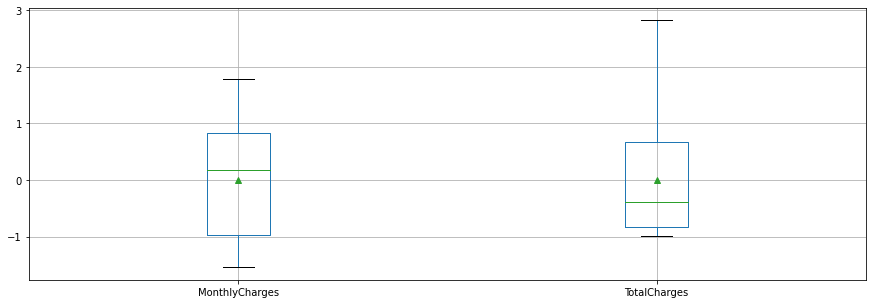

In [ ]:
#Graph
num = df[["MonthlyCharges","TotalCharges"]]
t = pd.DataFrame(StandardScaler().fit_transform(num), columns=num.columns)
plt.figure(figsize=(15,5))
t.boxplot(showmeans=True)
plt.show()


We could see from our numerical attributes, there is no outlier so we could continue the process.

## Data Visualization

__How many churn in the last month?__

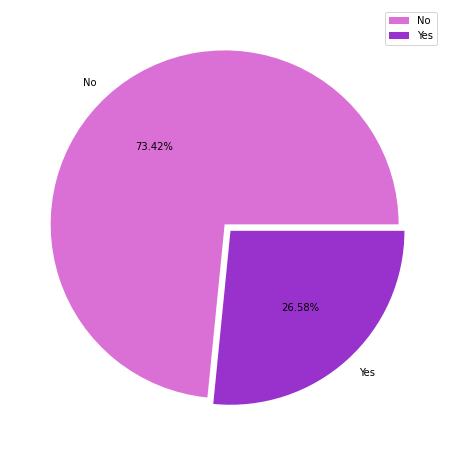

In [ ]:
#Query
q1 = df.groupby("Churn")["customerID"].count().reset_index()

#Graph
plt.figure(figsize=(8,8))
plt.pie(q1["customerID"], labels=q1["Churn"], autopct="%.2f%%" , explode=[0,0.05], colors=["orchid","darkorchid"])
plt.legend(q1["Churn"])
plt.show()

The rate of churn in last month is pretty high. It's 27 percent of dataset. This might be a concern for company to find out why customer tends to stop subscribing their service product. It might be based on its behaviour or else. And the other hand, company needs to more focus to keep the rest customer (73%) customer so they'll keep retained with the services.

__How tenure impacted customer leave?__

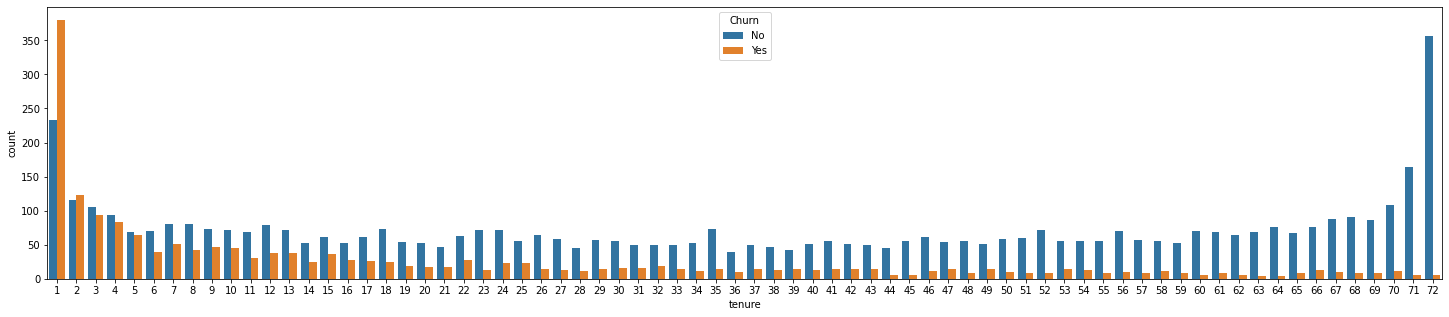

In [ ]:
#Graph
plt.figure(figsize=(25,5))
sns.countplot(x=df["tenure"] , hue=df["Churn"])
plt.legend(title="Churn")
plt.show()

Foucusing on total customer who left (Churn = Yes) we could see customer with tenure 1 mostly stop subscribing the service and it's decrease gradually as the tenure is higher.

We could guess, this churn happening because there are so many customer who subscribe the service because some beneficial promotion at first tenure but for the next tenure they decided to leave because there is not promotion anymore.

__How demographic attributes affecting total customer who leave?__

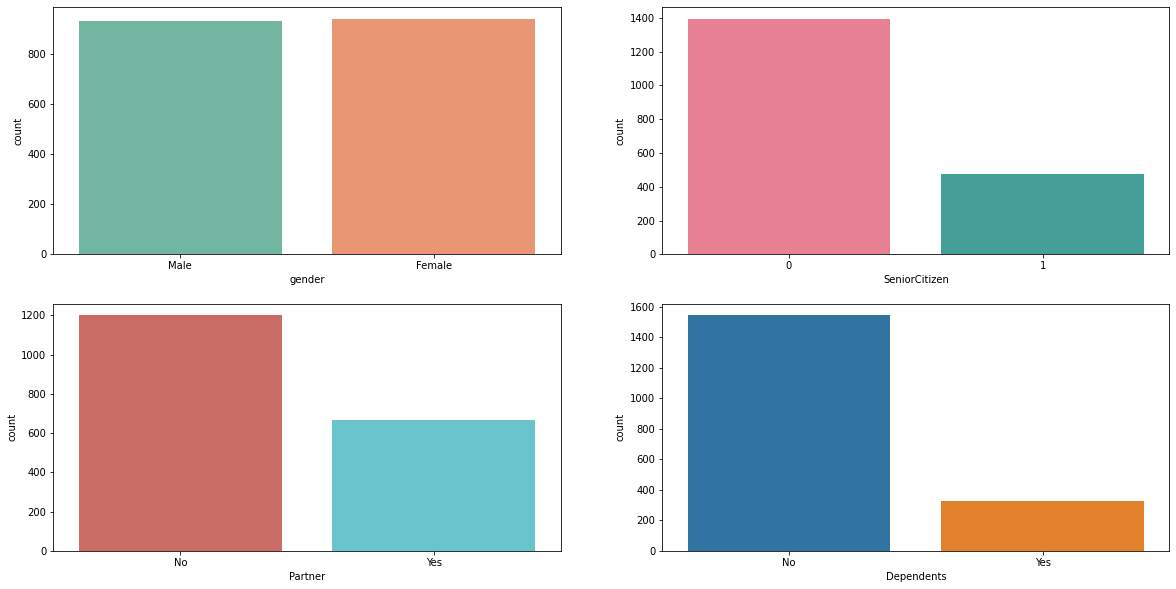

In [ ]:
#Graph
fig, ax = plt.subplots(2,2, figsize=(20,10))
sns.countplot(x=df[df["Churn"]=="Yes"]["gender"], ax= ax[0,0], palette="Set2")
sns.countplot(x=df[df["Churn"]=="Yes"]["SeniorCitizen"], ax= ax[0,1], palette="husl")
sns.countplot(x=df[df["Churn"]=="Yes"]["Partner"] , ax= ax[1,0] , palette="hls")
sns.countplot(x=df[df["Churn"]=="Yes"]["Dependents"], ax= ax[1,1], palette="tab10")
plt.show()

From graph we could see some insight based on total customer churn:
1. Female and male has same quantity.
2. Mostly senior citizen is churn. It might because typically senior citizen not really into using telephone and internet or not understand the benefit of service provided by Telco than the young citizen.
3. Customer who has partner , in this context we could say customer who already married is tend to churn.
4. It's also happening with customer who has dependents, they tend to churn.

From above we could conclude, gender is not affecting total customer of churn while age , marital and child might affecting. Senior citizen tend to churn , it might due to their low knowledge of telco services than the young citizen. While customer who already married or having children tend to churn because they might have another bills to pay for their family than only use for their handphone/telephone services.

__How is customer behaviour related their account attributes?__

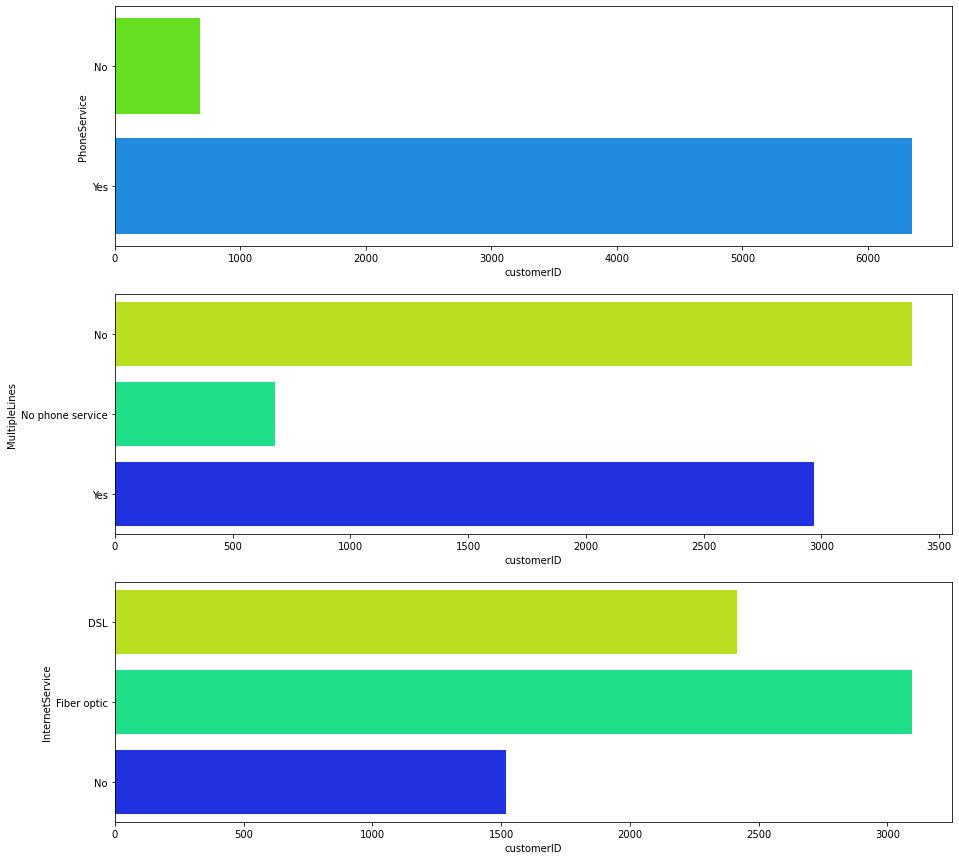

In [ ]:
#Query
q1 = df.groupby("PhoneService")["customerID"].count().reset_index()
q2 = df.groupby("MultipleLines")["customerID"].count().reset_index()
q3 = df.groupby("InternetService")["customerID"].count().reset_index()

fig,ax = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=q1 , x="customerID" , y="PhoneService", orient="h" , palette="gist_rainbow", ax=ax[0])
sns.barplot(data=q2 , x="customerID" , y="MultipleLines", orient="h" , palette="gist_rainbow", ax=ax[1])
sns.barplot(data=q3 , x="customerID" , y="InternetService", orient="h" , palette="gist_rainbow", ax=ax[2])
plt.show()


1. From all dataset total customer who subscribe Phone Service is high which more than 6000 customer.
2. Total customer who not subscribe MultipeLines is lower than customer who subscribe. When we see label "No Phone Service" and "No" actually have same meaning that means customer is not subscribe MultipleLines service. The difference is , label "No" indeed the customer has subscribed Phone Service but not Multiplelines.
3. Total customer who subscribe Internet Service is higher than who is not. But mostly they using "Fiber optic" than DSL.

From that, we could say Phone and Internet is most popular service subsribed by customer.

__How customer account attributes affecting total customer who leave?__

Now, we tried to divide customer into 2 category :
1. Customer who subscribed all services (Phone, MultipleLines and Internet)
2. Customer who atleast not subsribe 1 services.

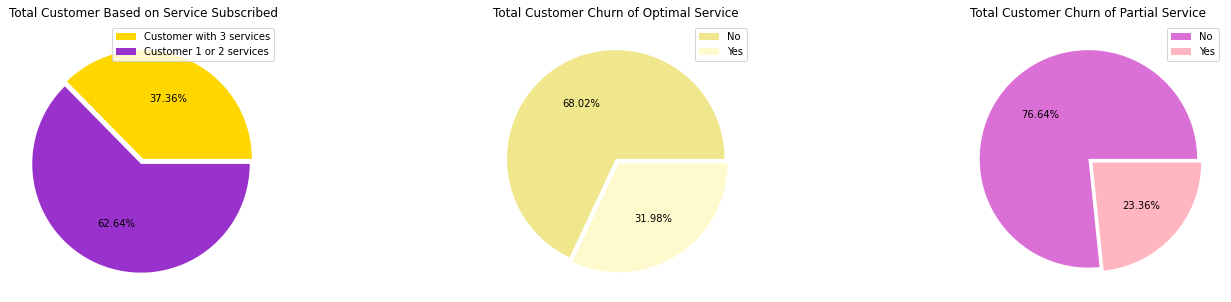

In [ ]:
#Query 
q4 = df[(df["PhoneService"]== "Yes") & (df["MultipleLines"]== "Yes") & (df["InternetService"].isin(["DSL","Fiber optic"]))]
q5 = pd.DataFrame({"Status": ["Customer with 3 services","Customer 1 or 2 services" ] ,
                   "Total": [q4["customerID"].count(),df["customerID"].count() - q4["customerID"].count()]})

q6 = q4.groupby("Churn")["customerID"].count().reset_index()
q7 = df[~df.index.isin(q4.index)].groupby("Churn")["customerID"].count().reset_index()

#Graph
fig,ax= plt.subplots(1,3, figsize=(24,5))
#plt.figure(figsize=(8,8))
ax[0].pie(q5["Total"],  autopct="%.2f%%" , explode=[0,0.05], colors=["gold","darkorchid"])
ax[0].legend(q5["Status"], loc="best")
ax[0].set_title("Total Customer Based on Service Subscribed")

ax[1].pie(q6["customerID"],  autopct="%.2f%%" , explode=[0,0.05], colors=["khaki","lemonchiffon"])
ax[1].legend(q6["Churn"], loc="best")
ax[1].set_title("Total Customer Churn of Optimal Service")

ax[2].pie(q7["customerID"],  autopct="%.2f%%" , explode=[0,0.05], colors=["orchid","lightpink"])
ax[2].legend(q7["Churn"], loc="best")
ax[2].set_title("Total Customer Churn of Partial Service")

plt.show()


From the graph we could see we have 37% customer who subscribe all services . It's pretty high and means good for company. 

Then when we take a look of each category related the portion on Churn customer we got some insight :
1. 32% of total customer who subsrcibe all services are decide to churn.
2. 23% of total customer who atleast not subscribe 1 services are decided to churn.

__Churn trend based on Internet Services__

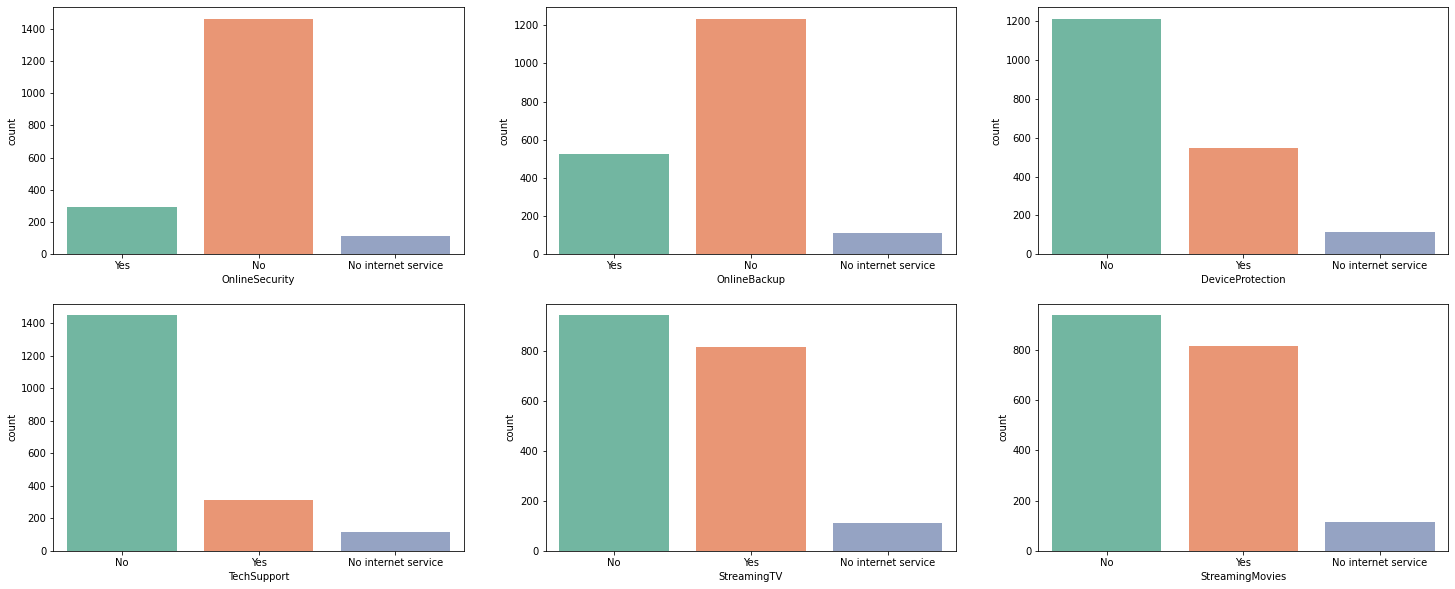

In [ ]:
#Graph
fig, ax = plt.subplots(2,3, figsize=(25,10))
sns.countplot(x=df[df["Churn"]=="Yes"]["OnlineSecurity"] , ax=ax[0,0], palette="Set2")
sns.countplot(x=df[df["Churn"]=="Yes"]["OnlineBackup"] , ax=ax[0,1],palette="Set2")
sns.countplot(x=df[df["Churn"]=="Yes"]["DeviceProtection"] , ax=ax[0,2],palette="Set2")
sns.countplot(x=df[df["Churn"]=="Yes"]["TechSupport"] , ax=ax[1,0],palette="Set2")
sns.countplot(x=df[df["Churn"]=="Yes"]["StreamingTV"] , ax=ax[1,1],palette="Set2")
sns.countplot(x=df[df["Churn"]=="Yes"]["StreamingMovies"] , ax=ax[1,2],palette="Set2")
plt.show()

From graph above, we could see almost all of sub Internet Service has high quantity of churn customer who not subscribe it (label "No"and "No Internet Service"). So we could conclude, mostly customer who decide to churn are not subscribing any sub Internet Services.

__Churn trend based on Payment or Contract__

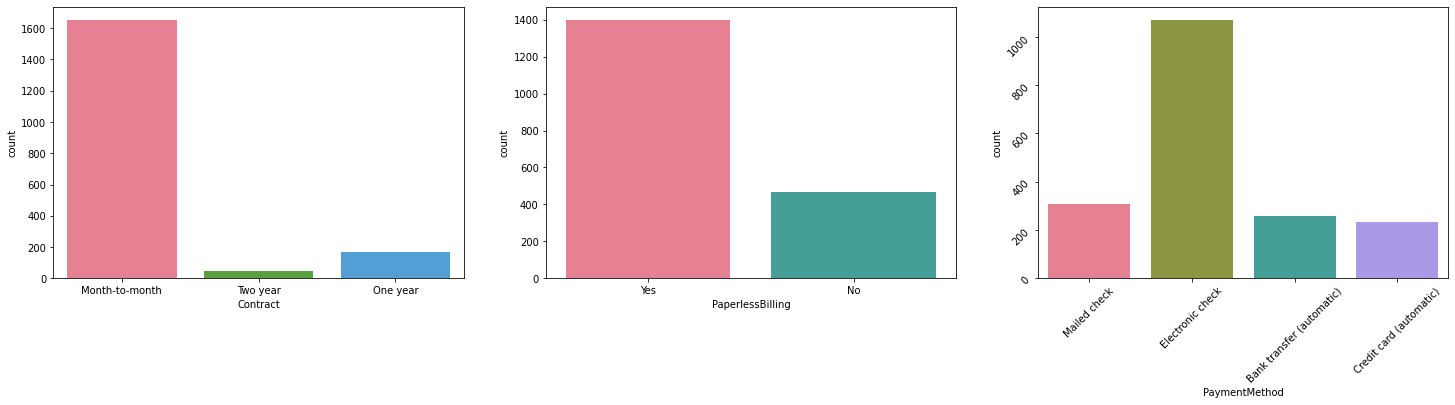

In [ ]:
#Graph
fig, ax = plt.subplots(1,3, figsize=(25,5))
sns.countplot(x=df[df["Churn"]=="Yes"]["Contract"] , ax=ax[0], palette="husl")
sns.countplot(x=df[df["Churn"]=="Yes"]["PaperlessBilling"] , ax=ax[1], palette="husl")
sns.countplot(x=df[df["Churn"]=="Yes"]["PaymentMethod"], ax=ax[2], palette="husl")
ax[2].tick_params(labelrotation=45)
plt.show()

From above graph, we could see trend customer who decided to Churn mostly their contract is Month-to-Month. Then from paperlessbilling , customer who use paperlessbilling tend to churn easly while from paymentmethod mostly electronic check customer tend to churn.

We could conclude customer who has contract month to month and using payment/billing electronic tend to churn because it's more easy to churn with no effort.

__Monthly Charges trend against Churn Customer__

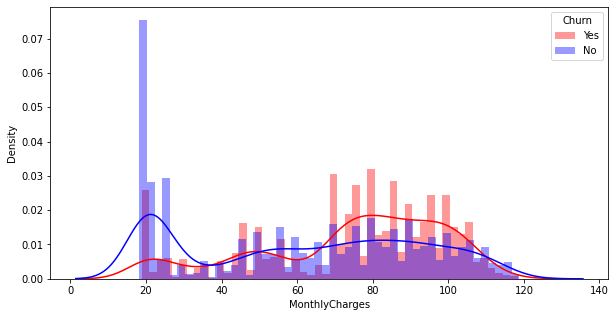

In [ ]:
#Graph
warnings.filterwarnings("ignore")
plt.figure(figsize=(10,5))
sns.distplot(df[df["Churn"]=="Yes"]["MonthlyCharges"], kde=True, color="r", label=["Yes"], bins=50)
sns.distplot(df[df["Churn"]=="No"]["MonthlyCharges"], kde=True, color="b", label=["No"], bins=50)
plt.legend(title="Churn")
plt.show()

We could see trend customer churn(red graph) mostly customer with monthly charges 70 - 100 while the retained customer mostly has monthly charges around 20.

We could conclude, customer who has high monthly charge tend to churn while our loyal customer mostly has low monthly charge.


__Total Charges trend against Churn Customer__

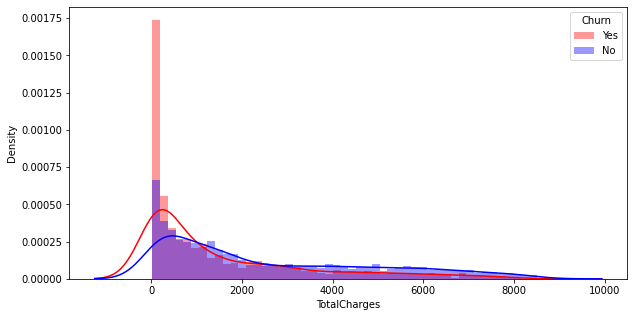

In [ ]:
#Graph
warnings.filterwarnings("ignore")
plt.figure(figsize=(10,5))
sns.distplot(df[df["Churn"]=="Yes"]["TotalCharges"], kde=True, color="r", label=["Yes"], bins =50)
sns.distplot(df[df["Churn"]=="No"]["TotalCharges"], kde=True, color="b", label=["No"], bins=50)
plt.legend(title="Churn")
plt.show()

From total charges perpective, since mostly churn customer has high monthly charge it's inline with total charge. Customer churn mostly has high total charge.

We could conclude, loyal customer is not customer who pay high for their service but customer who has high bills are the churn customer.

__Correlation monthly and total charges__

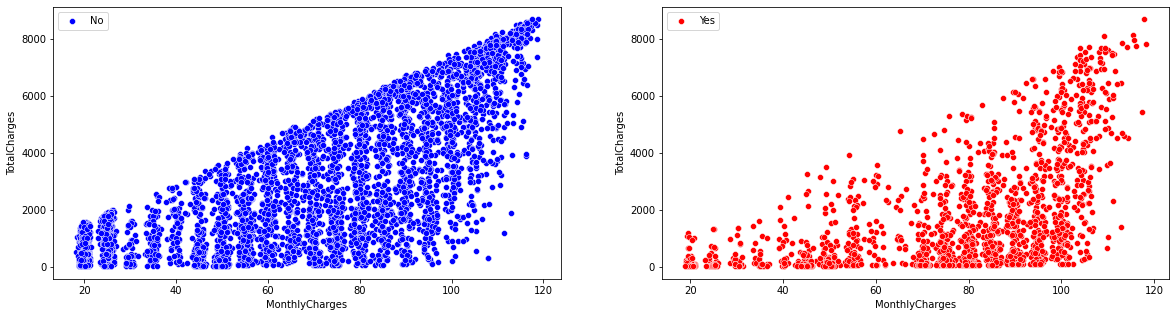

In [ ]:
#Graph
warnings.filterwarnings("ignore")
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.scatterplot(y=df[df["Churn"]=="No"]["TotalCharges"] ,x =df[df["Churn"]=="No"]["MonthlyCharges"] , color="b", label="No", ax = ax[0])
sns.scatterplot(y=df[df["Churn"]=="Yes"]["TotalCharges"] ,x =df[df["Churn"]=="Yes"]["MonthlyCharges"] , color="r", label="Yes", ax = ax[1])
#plt.legend(title="Churn")
plt.show()

We could see both of graph from retained customer (left graph) and churn customer (right graph) has same pattern between monthlyCharges and TotalCharges.

Both of attributes has low correlation which if monthly charges increase, total charges also increase but not exponentially. There is still high monthly charges who has low total charges. 

## Data PreProcessing

In this section we will do some activities to prepare our dataset before go to modeling. 
1. Split some dataset to become our test data.
2. Feature selection for numerical and categorical attributes.
3. Creating preprocessing pipeline for dataset.

### Split Dataset

In [ ]:
#split data to train ,test and sample
train_full, test = train_test_split(df, test_size=0.1, random_state=42, shuffle=True, stratify=df["Churn"])
train, valid = train_test_split(train_full, test_size=0.2, random_state=42, shuffle=True, stratify=train_full["Churn"])

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
valid = valid.reset_index(drop=True)

print("Total of training data     : ", train.shape[0])
print("Total of testing  data     : ", test.shape[0])
print("Total of validation data   : ", valid.shape[0])


Total of training data     :  5062
Total of testing  data     :  704
Total of validation data   :  1266


In [ ]:
#Split numerical and categorical dataset
num_df = train_full[["MonthlyCharges","TotalCharges"]]
cat_df = train_full.drop(["MonthlyCharges","TotalCharges","customerID","Churn"],axis=1)

### Feature Selection

For feature selection, we will divide it into 2 group :
1. We will use SelectKBest with ANNOVA approach between numerical features with target variable.
2. We will use SelectKBest with chi2 square approach to find out correlation between categorical features with target variable

Our target data is Genre which represents which genre the song is included.

#### Numerical Feature Selection

We will check if there is multicollinearity between numerical attributes. 

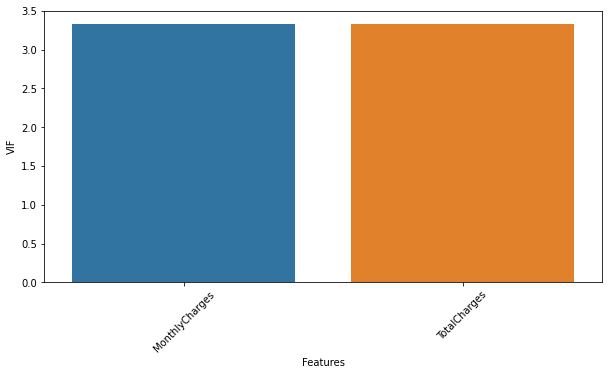

Features       VIF
0  MonthlyCharges  3.337896
1    TotalCharges  3.337896

In [ ]:
#Define VIF dataFrame
vif_data= pd.DataFrame()
vif_data["Features"] = num_df.columns

#Calculate VIF 
vif_data["VIF"] = [variance_inflation_factor(num_df.values, i)
                    for i in range(len(num_df.columns))]

#Graph
plt.figure(figsize=(10,5))
sns.barplot(x=vif_data["Features"], y=vif_data["VIF"])
plt.xticks(rotation=45)
plt.show()

vif_data

We will use Annova Approach for selecting numerical features. We will use alpha = 0.05

- H0 : Variance of each genre in feature are same
- H1 : Variance of each genre in featurea are different

P-Value of Feature MonthlyCharges : 0.0000000 
P-Value of Feature TotalCharges : 0.0000000 



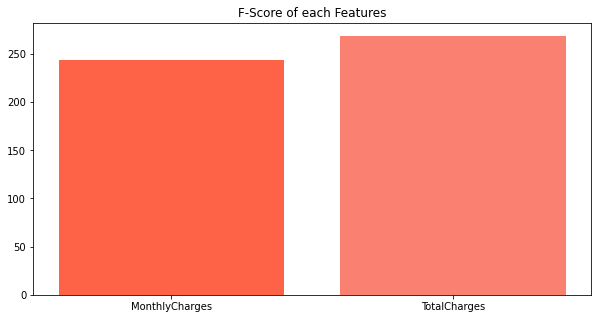

In [ ]:
#Scaling the numerical features
sc = StandardScaler()
num_dfs = sc.fit_transform(num_df)

#Scaling target
lc = LabelEncoder()
y = lc.fit_transform(train_full["Churn"])

#Define Feature Selection with ANNOVA approach
fs_num = SelectKBest(score_func=f_classif, k='all')

#Apply numerical feature selection to Training Data
X_features_num = fs_num.fit_transform(num_dfs, y)
fs_num.scores_

#what are scores for the features
for col in list(num_df.columns):
  score = fs_num.pvalues_[num_df.columns.get_loc(col)]
  print("P-Value of Feature %s : %.7f " %(col , score))
print("")

#barplot
plt.figure(figsize=(10,5))
plt.bar([col for col in list(num_df.columns)], fs_num.scores_ , color=["tomato","salmon"])
plt.title("F-Score of each Features")
plt.show()


Above result, represent all features has P-Values below our alpha . It means variance of churn in all features are different , we could say reject H0.

The F-Score of each features are vary. It's representing that each Churn of each features has its own variance and divide well. 

So from above result, we decide to use all the numerical feature as part of our modeling.

#### Categorical Feature Selection

Feature gender : 0.71 
Feature SeniorCitizen : 121.66 
Feature Partner : 75.68 
Feature Dependents : 121.31 
Feature tenure : 15331.46 
Feature PhoneService : 0.09 
Feature MultipleLines : 9.91 
Feature InternetService : 9.16 
Feature OnlineSecurity : 516.51 
Feature OnlineBackup : 208.61 
Feature DeviceProtection : 169.92 
Feature TechSupport : 484.06 
Feature StreamingTV : 6.46 
Feature StreamingMovies : 8.08 
Feature Contract : 1008.85 
Feature PaperlessBilling : 94.47 
Feature PaymentMethod : 56.66 



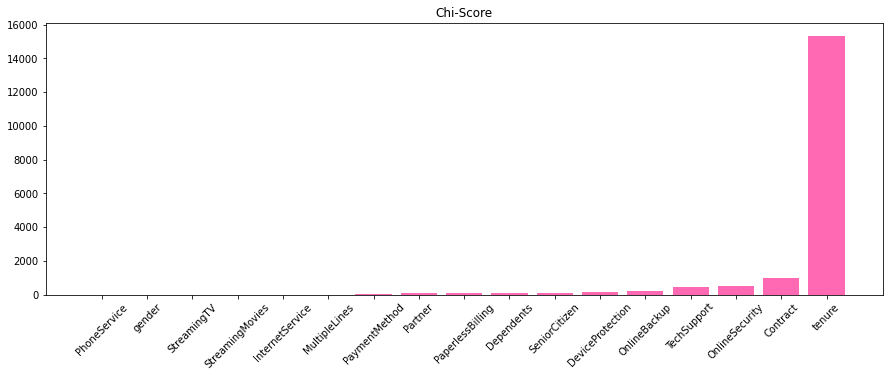

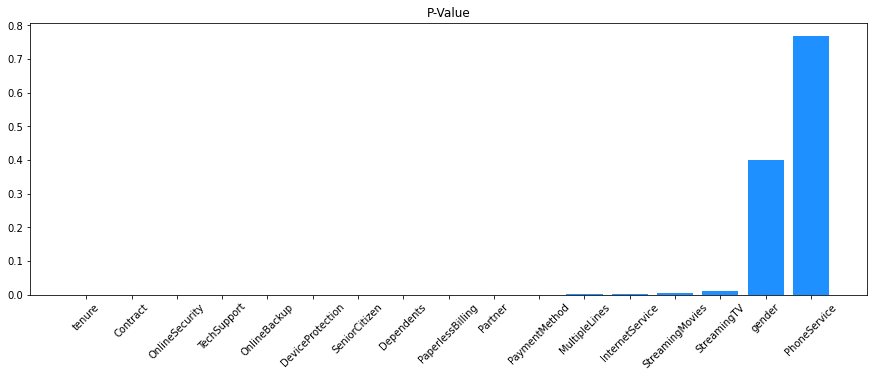

In [ ]:
#Scaling categorical features
oc = OrdinalEncoder()
cat_dfs = oc.fit_transform(cat_df)

#Define Feature Selection with Chi-Square approach
fs_cat = SelectKBest(score_func=chi2, k='all')

#Apply categorical feature selection to Training Data
X_features_cat = fs_cat.fit_transform(cat_dfs, y)

# what are scores for the features
for col in list(cat_df.columns):
  score = fs_cat.scores_[cat_df.columns.get_loc(col)]
  print("Feature %s : %.2f " %(col , score))
print("")


#barplot
chi = pd.DataFrame({"Columns":cat_df.columns, "Chi-Score":fs_cat.scores_}).sort_values(by=['Chi-Score'])
plt.figure(figsize=(15,5));
plt.bar(chi['Columns'], chi["Chi-Score"], color="hotpink");
plt.xticks(rotation=45 );
plt.title("Chi-Score")
plt.show()

#barplot
pvalue = pd.DataFrame({"Columns":cat_df.columns, "P-Value":fs_cat.pvalues_}).sort_values(by=['P-Value'])
plt.figure(figsize=(15,5));
plt.bar(pvalue["Columns"], pvalue["P-Value"], color="dodgerblue");
plt.xticks(rotation=45 );
plt.title("P-Value")
plt.show()


Above information represent the correlation via Chi-Square approach between our categorical features with the target. High score of Chi-Square of features means it has high relation/correlation with the target. 

So in this case, we will choose only 6 top features that has high correlation with Genre to be used in our model :
1. tenure
2. Contract
3. OnlineSecurity
4. TechSupport
5. OnlineBackup
6. DeviceProtection

#### Final Features 

Below are our final features for modeling classification purposes.

1. MontlyCharges
2. TotalCharges
3. tenure
4. Contract
5. OnlineSecurity
6. TechSupport
7. OnlineBackup
8. DeviceProtection

### Dataset Preparation

Below we're going to divide our target against the features for modeling purpose.

In [ ]:
## Define train and validation set features

X_train = train[["MonthlyCharges","TotalCharges","tenure","Contract","OnlineSecurity","TechSupport","OnlineBackup","DeviceProtection"]]
y_train = np.array([1 if x == "Yes" else 0 for x in train["Churn"]])

X_valid = valid[["MonthlyCharges","TotalCharges","tenure","Contract","OnlineSecurity","TechSupport","OnlineBackup","DeviceProtection"]]
y_valid = np.array([1 if x == "Yes" else 0 for x in valid["Churn"]])

X_test = test[["MonthlyCharges","TotalCharges","tenure","Contract","OnlineSecurity","TechSupport","OnlineBackup","DeviceProtection"]]
y_test = np.array([1 if x == "Yes" else 0 for x in test["Churn"]])

### Preprocessing Pipeline


In [ ]:
#PreProcess Final Pipeline
PrePipeline = FeatureUnion(
    transformer_list=[
        ("Numeric", Pipeline([ 
              ("SelectorNum", ColumnSelector(["MonthlyCharges","TotalCharges"])), 
              ("Scaler", StandardScaler())  
        ])),
        ("Categoric", Pipeline([
              ("SelectorCat", ColumnSelector(["tenure","Contract","OnlineSecurity","TechSupport","OnlineBackup","DeviceProtection"])),
              ("Scaler", OrdinalEncoder()) 
        ]))  
    ]
)

In [ ]:
#Fit prepipeline
PrePipeline.fit(X_train)

FeatureUnion(n_jobs=None,
             transformer_list=[('Numeric',
                                Pipeline(memory=None,
                                         steps=[('SelectorNum',
                                                 ColumnSelector(cols=['MonthlyCharges',
                                                                      'TotalCharges'],
                                                                drop_axis=False)),
                                                ('Scaler',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True))],
                                         verbose=False)),
                               ('Categoric',
                                Pipeline(memory=None,
                                         steps=[('SelectorCat',
                                      

In [ ]:
#result of dataset preprocessing
X_trains = PrePipeline.transform(X_train)
X_valids = PrePipeline.transform(X_valid)
X_tests = PrePipeline.transform(X_test)

## Model Definition and Training

### Sequential Basic ANN

In this sequential model of ANN we will use 3 hidden layers with "relu" activation and HeUniform initilizer since it uses relu as activation. Each layer will have total neurons (128,64 and 32). And for output layer we will use activation sigmoid since goals of model is a binary classification.


#### Model Definition

In [ ]:
#Set random seed
tf.keras.backend.clear_session
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Build model architecture
s_model = keras.models.Sequential()
s_model.add(keras.Input(shape=[8]))
s_model.add(keras.layers.Dense(128, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42)))
s_model.add(keras.layers.Dense(64, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42)))
s_model.add(keras.layers.Dense(32, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42)))
s_model.add(keras.layers.Dense(1, activation="sigmoid"))

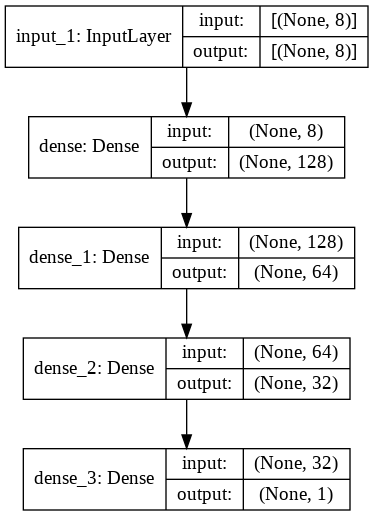

In [ ]:
#show the result of architecture
keras.utils.plot_model(s_model, show_shapes=True)

In [ ]:
#Summary model
s_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
_________________________________________________________________


In model compile, we will us binnary_classentropy for loss method because our target is binary classification and for optimizer we will use basic opimizer which SGD. 

We also will save the best epoch from training model so we could use it later for evaluation compared with others model.

In [ ]:
#Checkpoint definition
s_model_cp = tf.keras.callbacks.ModelCheckpoint(
    "basic_sequential_ANN.h5",
    monitor = "val_auc",
    save_best_only=True
)

#Compile the model
s_model.compile(loss="binary_crossentropy", 
                optimizer=keras.optimizers.SGD(learning_rate=0.01), 
                metrics=["AUC","Precision","Recall","FalseNegatives","FalsePositives","TrueNegatives","TruePositives","accuracy"])

#### Train Model

We will use 100 epochs for this training.

In [ ]:
#Train the model
s_history = s_model.fit(X_trains, y_train, epochs=100,
                      validation_data= (X_valids,y_valid), verbose =2, callbacks =[s_model_cp])

Epoch 1/100
159/159 - 3s - loss: 0.8018 - auc: 0.7333 - precision: 0.5282 - recall: 0.0558 - false_negatives: 1270.0000 - false_positives: 67.0000 - true_negatives: 3650.0000 - true_positives: 75.0000 - accuracy: 0.7359 - val_loss: 0.4944 - val_auc: 0.7781 - val_precision: 0.7500 - val_recall: 0.0890 - val_false_negatives: 307.0000 - val_false_positives: 10.0000 - val_true_negatives: 919.0000 - val_true_positives: 30.0000 - val_accuracy: 0.7496
Epoch 2/100
159/159 - 0s - loss: 0.4789 - auc: 0.7896 - precision: 0.7576 - recall: 0.1859 - false_negatives: 1095.0000 - false_positives: 80.0000 - true_negatives: 3637.0000 - true_positives: 250.0000 - accuracy: 0.7679 - val_loss: 0.5452 - val_auc: 0.7924 - val_precision: 0.7903 - val_recall: 0.1454 - val_false_negatives: 288.0000 - val_false_positives: 13.0000 - val_true_negatives: 916.0000 - val_true_positives: 49.0000 - val_accuracy: 0.7622
Epoch 3/100
159/159 - 0s - loss: 0.4672 - auc: 0.8024 - precision: 0.7350 - recall: 0.2639 - false_ne

### Functional API Basic ANN

For functional API ANN we will use same hyperparameter like basic Sequential API which using 3 hidden layers with "relu" activation and HeUniform initilizer since it uses relu as activation. Each layer will have total neurons (128,64 and 32). And for output layer we will use activation sigmoid since goals of model is a binary classification.

But for functional API, we will add a concatenate layer between hidden layer1 and hidden layer2 to make it different with the sequential ANN.

#### Model Definition

In [ ]:
#Set random seed
tf.keras.backend.clear_session
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
#Build the architecture
input = keras.layers.Input(shape=[8])
hid1 = keras.layers.Dense(128, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42))(input)
con = keras.layers.concatenate([input,hid1])
hid2 = keras.layers.Dense(64, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42))(con)
hid3 = keras.layers.Dense(32, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42))(hid2)
output = keras.layers.Dense(1, activation="sigmoid")(hid3)

f_model = keras.models.Model(inputs=[input], outputs=[output])

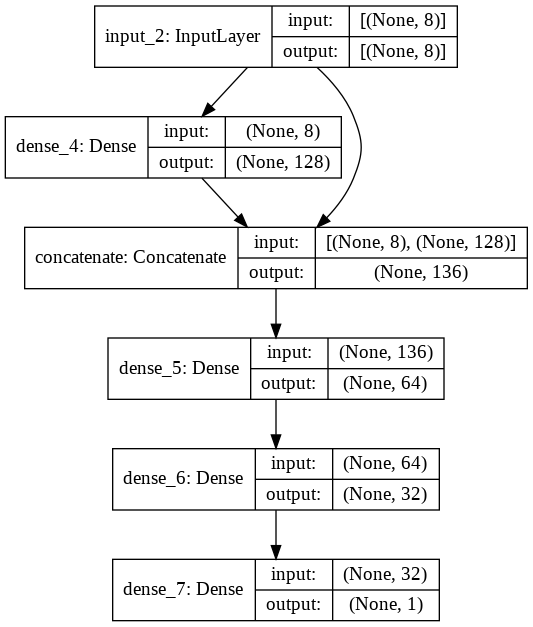

In [ ]:
#show the result of architecture
keras.utils.plot_model(f_model, show_shapes=True)

In [ ]:
#Summary model
f_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 136)          0           input_2[0][0]                    
                                                                 dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8768        concatenate[0][0]            

Same with sequential model compile, we will us binnary_classentropy for loss method because our target is binary classification and for optimizer we will use basic opimizer which SGD. 

We also will save the best epoch from training model so we could use it later for evaluation compared with others model.

In [ ]:
#Checkpoint definition
f_model_cp = tf.keras.callbacks.ModelCheckpoint(
    "basic_functional_ANN.h5",
    monitor = "val_auc",
    save_best_only=True
)


#Compile the model
f_model.compile(loss="binary_crossentropy", 
                optimizer=keras.optimizers.SGD(learning_rate=0.01), 
                metrics=["AUC","Precision","Recall","FalseNegatives","FalsePositives","TrueNegatives","TruePositives","accuracy"])



#### Train Model

Same with sequential, we also use 100 epoch for training.

In [ ]:
#Train the model
f_history = f_model.fit(X_trains, y_train, epochs=100,
                      validation_data= (X_valids,y_valid), verbose =2, callbacks=[f_model_cp])

Epoch 1/100
159/159 - 3s - loss: 0.7061 - auc: 0.7361 - precision: 0.4017 - recall: 0.0349 - false_negatives: 1298.0000 - false_positives: 70.0000 - true_negatives: 3647.0000 - true_positives: 47.0000 - accuracy: 0.7298 - val_loss: 0.5037 - val_auc: 0.8081 - val_precision: 0.6491 - val_recall: 0.1098 - val_false_negatives: 300.0000 - val_false_positives: 20.0000 - val_true_negatives: 909.0000 - val_true_positives: 37.0000 - val_accuracy: 0.7472
Epoch 2/100
159/159 - 0s - loss: 0.4700 - auc: 0.8023 - precision: 0.7212 - recall: 0.2000 - false_negatives: 1076.0000 - false_positives: 104.0000 - true_negatives: 3613.0000 - true_positives: 269.0000 - accuracy: 0.7669 - val_loss: 0.5389 - val_auc: 0.8010 - val_precision: 0.7176 - val_recall: 0.1810 - val_false_negatives: 276.0000 - val_false_positives: 24.0000 - val_true_negatives: 905.0000 - val_true_positives: 61.0000 - val_accuracy: 0.7630
Epoch 3/100
159/159 - 0s - loss: 0.4553 - auc: 0.8139 - precision: 0.7355 - recall: 0.3019 - false_n

### Basic Model Evaluation

We've tried to create 2 model before :
1. Basic Sequential ANN
2. Basic Functional API ANN

In this section, we'll try to see the evaluation between those 2 models.

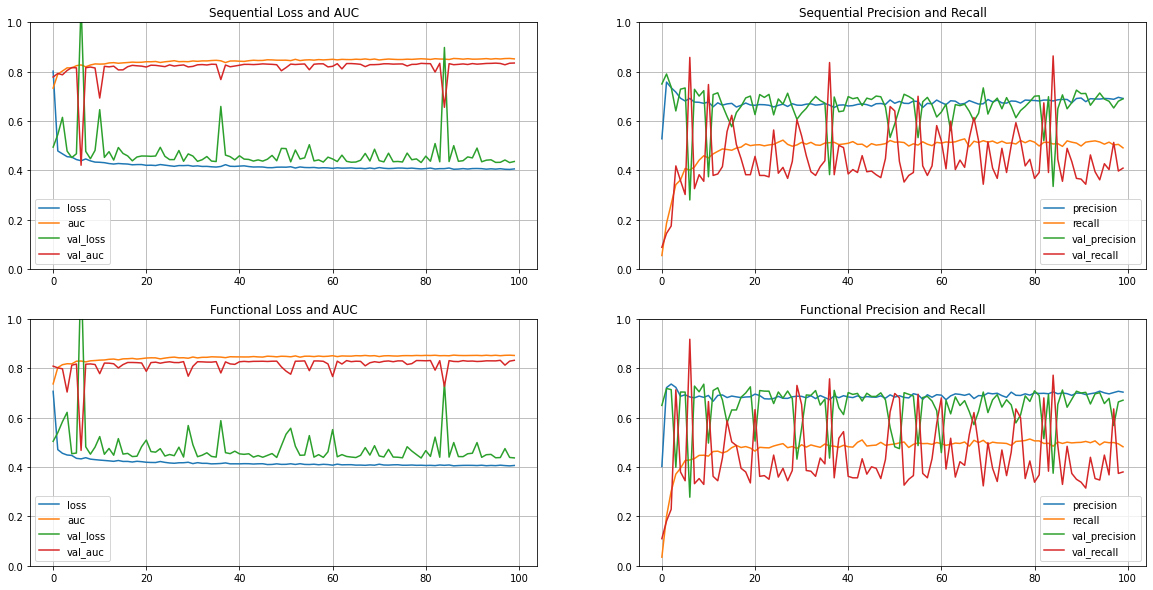

In [ ]:
#Evaluation Sequential API
s_loss_auc = {k: s_history.history[k] for k in ["loss","auc","val_loss","val_auc"]}
s_prec_rec = {k: s_history.history[k] for k in ["precision","recall","val_precision","val_recall"]}

#Evaluation Functional API
f_loss_auc = {k: f_history.history[k] for k in ["loss","auc","val_loss","val_auc"]}
f_prec_rec = {k: f_history.history[k] for k in ["precision","recall","val_precision","val_recall"]}

fig, ax = plt.subplots(2,2,figsize=(20, 10))

plt.rcParams['axes.grid'] = True
plt.setp(ax, ylim=(0,1))
pd.DataFrame(s_loss_auc).plot(ax=ax[0,0])
ax[0,0].set_title("Sequential Loss and AUC")
pd.DataFrame(s_prec_rec).plot(ax=ax[0,1])
ax[0,1].set_title("Sequential Precision and Recall")

pd.DataFrame(f_loss_auc).plot(ax=ax[1,0])
ax[1,0].set_title("Functional Loss and AUC")
pd.DataFrame(f_prec_rec).plot(ax=ax[1,1])
ax[1,1].set_title("Functional Precision and Recall")

#plt.savefig("Adam_BNorm_Drop.png")
plt.show()

If we see the graph at a glance, the epoch evaluation movement of sequential or functional API is not far different. The val_loss of both model are a bit fluctuated around 0,4 - 0,6 while the val_AUC value are around 0,8 - 0,9.

But looking at for validation recall and precision for both model, it looks highly fluctuated. Both model has val_recall around 0,3 - 0,9 while the val_precision around 0,6-0,8.

While comparing to train evaluation value, both are seems constant. We could conclude both of model are overfitting. So for next , we will try to do some tuning to make our model better.

## Model Fine-Tunning


### Basic Model Tunning

Recalling our evaluation movement of both basic sequential and functional ANN model before, it's resulting model which has flucuated movement of evaluation value and leading to overfit.

In this tunning,  we'll try to maximize our basic model ANN before using some technique such as Batch Normalization and Dropout for each hidden layer. We're expecting get more constant evaluation with less overfit/underfit model.

#### Tunned Sequential Model

In [ ]:
#Set random seed
tf.keras.backend.clear_session
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Build model architecture
tun_s_model = keras.models.Sequential()
tun_s_model.add(keras.Input(shape=[8]))
tun_s_model.add(keras.layers.BatchNormalization())
tun_s_model.add(keras.layers.Dropout(rate=0.2))
tun_s_model.add(keras.layers.Dense(128, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42)))
tun_s_model.add(keras.layers.BatchNormalization())
tun_s_model.add(keras.layers.Dropout(rate=0.2))
tun_s_model.add(keras.layers.Dense(64, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42)))
tun_s_model.add(keras.layers.BatchNormalization())
tun_s_model.add(keras.layers.Dropout(rate=0.2))
tun_s_model.add(keras.layers.Dense(32, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42)))
tun_s_model.add(keras.layers.Dense(1, activation="sigmoid"))

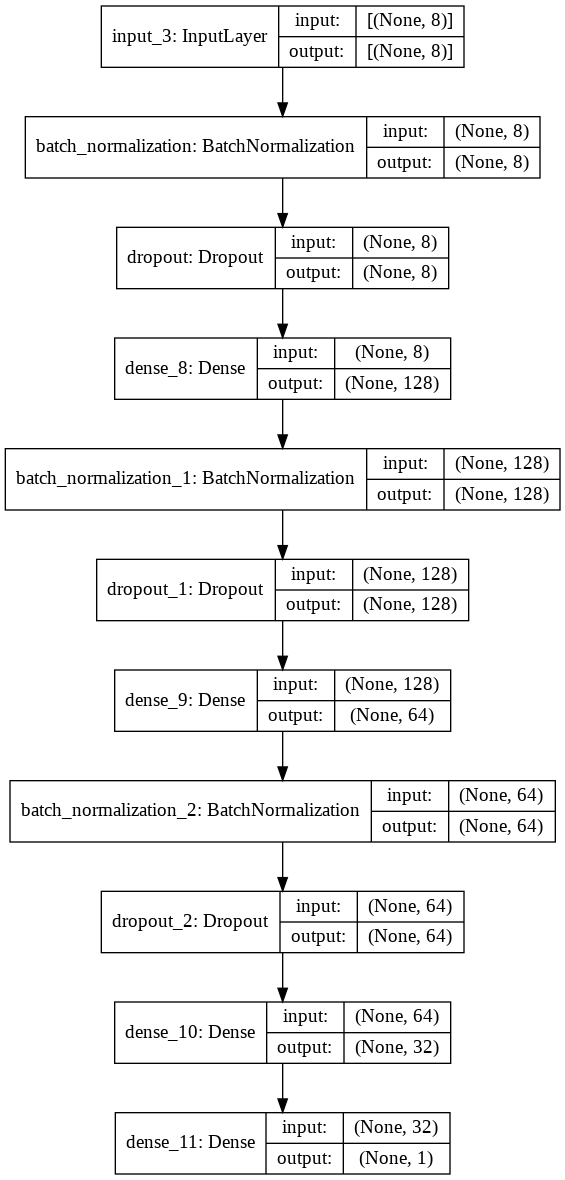

In [ ]:
#show the result of architecture
keras.utils.plot_model(tun_s_model, show_shapes=True)

Same as previous model, here we will save the best model too.

In [ ]:
#Checkpoint definition
tun_s_model_cp = tf.keras.callbacks.ModelCheckpoint(
    "tun_basic_sequential_ANN.h5",
    monitor = "val_auc",
    save_best_only=True
)

#Compile the model
tun_s_model.compile(loss="binary_crossentropy", 
                optimizer=keras.optimizers.SGD(learning_rate=0.01), 
                metrics=["AUC","Precision","Recall","FalseNegatives","FalsePositives","TrueNegatives","TruePositives","accuracy"])

In [ ]:
#Train the model
tun_s_history = tun_s_model.fit(X_trains, y_train, epochs=100,
                      validation_data= (X_valids,y_valid), verbose =2, callbacks=[tun_s_model_cp])

Epoch 1/100
159/159 - 3s - loss: 0.5732 - auc: 0.6910 - precision: 0.4382 - recall: 0.4030 - false_negatives: 803.0000 - false_positives: 695.0000 - true_negatives: 3022.0000 - true_positives: 542.0000 - accuracy: 0.7041 - val_loss: 0.4651 - val_auc: 0.7988 - val_precision: 0.5709 - val_recall: 0.4421 - val_false_negatives: 188.0000 - val_false_positives: 112.0000 - val_true_negatives: 817.0000 - val_true_positives: 149.0000 - val_accuracy: 0.7630
Epoch 2/100
159/159 - 0s - loss: 0.5036 - auc: 0.7572 - precision: 0.5273 - recall: 0.4230 - false_negatives: 776.0000 - false_positives: 510.0000 - true_negatives: 3207.0000 - true_positives: 569.0000 - accuracy: 0.7460 - val_loss: 0.4563 - val_auc: 0.8080 - val_precision: 0.5744 - val_recall: 0.4926 - val_false_negatives: 171.0000 - val_false_positives: 123.0000 - val_true_negatives: 806.0000 - val_true_positives: 166.0000 - val_accuracy: 0.7678
Epoch 3/100
159/159 - 0s - loss: 0.4876 - auc: 0.7743 - precision: 0.5561 - recall: 0.3941 - fal

#### Tunned Functional API Model

Below are tunned version model from functional API ANN with batchnormalization and dropout.

In [ ]:
#Set random seed
tf.keras.backend.clear_session
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Build the architecture
t_input = keras.layers.Input(shape=[8])

t_bn1 = keras.layers.BatchNormalization()(t_input)
t_dp1 = keras.layers.Dropout(rate=0.2)(t_bn1)
t_hid1 = keras.layers.Dense(128, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42))(t_dp1)
t_con = keras.layers.concatenate([t_input,t_hid1])

t_bn2 = keras.layers.BatchNormalization()(t_con)
t_dp2 = keras.layers.Dropout(rate=0.2)(t_bn2)
t_hid2 = keras.layers.Dense(64, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42))(t_dp2)

t_bn3 = keras.layers.BatchNormalization()(t_hid2)
t_dp3 = keras.layers.Dropout(rate=0.2)(t_bn3)
t_hid3 = keras.layers.Dense(32, activation="relu", kernel_initializer=keras.initializers.HeUniform(seed=42))(t_dp3)
t_output = keras.layers.Dense(1, activation="sigmoid")(t_hid3)

tun_f_model = keras.models.Model(inputs=[t_input], outputs=[t_output])

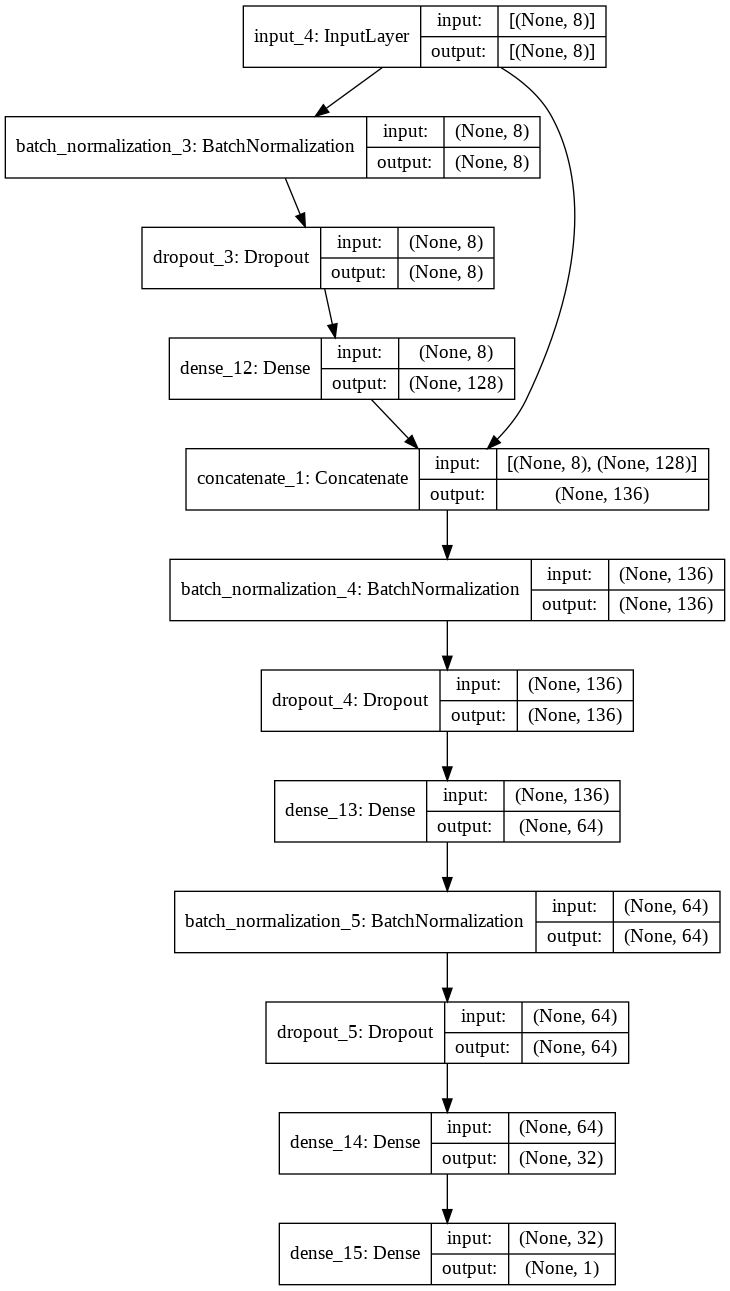

In [ ]:
#show the result of architecture
keras.utils.plot_model(tun_f_model, show_shapes=True)

We will save the best model too for later evaluation.

In [ ]:
#Checkpoint definition
tun_f_model_cp = tf.keras.callbacks.ModelCheckpoint(
    "tun_basic_functional_ANN.h5",
    monitor = "val_auc",
    save_best_only=True
)

#Compile the model
tun_f_model.compile(loss="binary_crossentropy", 
                optimizer=keras.optimizers.SGD(learning_rate=0.01), 
                metrics=["AUC","Precision","Recall","FalseNegatives","FalsePositives","TrueNegatives","TruePositives","accuracy"])

In [ ]:
#Train the model
tun_f_history = tun_f_model.fit(X_trains, y_train, epochs=100,
                      validation_data= (X_valids,y_valid), verbose =2, callbacks=[tun_f_model_cp])

Epoch 1/100
159/159 - 3s - loss: 0.5707 - auc: 0.6964 - precision: 0.4510 - recall: 0.4483 - false_negatives: 742.0000 - false_positives: 734.0000 - true_negatives: 2983.0000 - true_positives: 603.0000 - accuracy: 0.7084 - val_loss: 0.4631 - val_auc: 0.8020 - val_precision: 0.6033 - val_recall: 0.5371 - val_false_negatives: 156.0000 - val_false_positives: 119.0000 - val_true_negatives: 810.0000 - val_true_positives: 181.0000 - val_accuracy: 0.7828
Epoch 2/100
159/159 - 0s - loss: 0.4921 - auc: 0.7703 - precision: 0.5387 - recall: 0.4290 - false_negatives: 768.0000 - false_positives: 494.0000 - true_negatives: 3223.0000 - true_positives: 577.0000 - accuracy: 0.7507 - val_loss: 0.4524 - val_auc: 0.8123 - val_precision: 0.6489 - val_recall: 0.4332 - val_false_negatives: 191.0000 - val_false_positives: 79.0000 - val_true_negatives: 850.0000 - val_true_positives: 146.0000 - val_accuracy: 0.7867
Epoch 3/100
159/159 - 0s - loss: 0.4861 - auc: 0.7779 - precision: 0.5621 - recall: 0.3970 - fals

#### Tunned Basic Model Evaluation

Below are the evaluation of both tunned model of sequential and functional model.

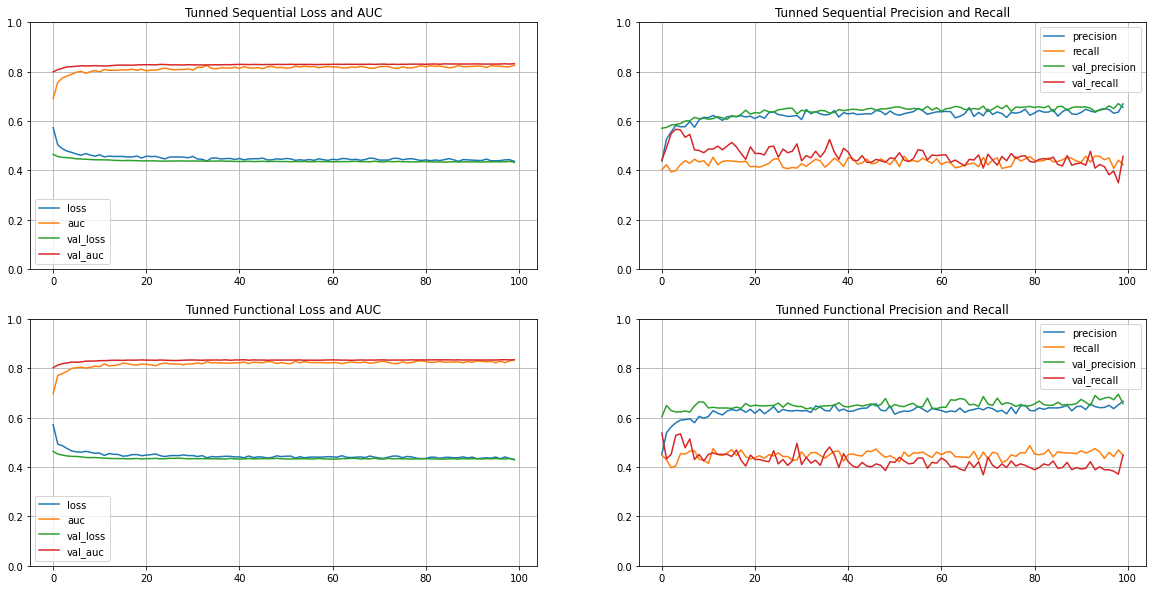

In [ ]:
#Evaluation Tunned Sequential API
tun_s_loss_auc = {k: tun_s_history.history[k] for k in ["loss","auc","val_loss","val_auc"]}
tun_s_prec_rec = {k: tun_s_history.history[k] for k in ["precision","recall","val_precision","val_recall"]}

#Evaluation Tunned  Functional API
tun_f_loss_auc = {k: tun_f_history.history[k] for k in ["loss","auc","val_loss","val_auc"]}
tun_f_prec_rec = {k: tun_f_history.history[k] for k in ["precision","recall","val_precision","val_recall"]}

fig, ax = plt.subplots(2,2,figsize=(20, 10))

plt.rcParams['axes.grid'] = True
plt.setp(ax, ylim=(0,1))
pd.DataFrame(tun_s_loss_auc).plot(ax=ax[0,0])
ax[0,0].set_title("Tunned Sequential Loss and AUC")
pd.DataFrame(tun_s_prec_rec).plot(ax=ax[0,1])
ax[0,1].set_title("Tunned Sequential Precision and Recall")

pd.DataFrame(tun_f_loss_auc).plot(ax=ax[1,0])
ax[1,0].set_title("Tunned Functional Loss and AUC")
pd.DataFrame(tun_f_prec_rec).plot(ax=ax[1,1])
ax[1,1].set_title("Tunned Functional Precision and Recall")

#plt.savefig("Adam_BNorm_Drop.png")
plt.show()

Look, after we add tunning such as batch normalization and dropout at every hidden layer, both of sequential or functional model have more constant value of val_auc and val_loss. It's happening too with its recall and precision value eventhough we havent got very constant of these value.

We could conclude we've got more stabil models of both models eventhough the value might different little bit.

But if we comparing sequential tunned model vs functional tunned model, the better model might be Sequential Tunned Model. It's because that model has the most not overfit /underfit value based on recall and precision evaluation. We could see from top of right graph, the lines of val_precision and val_recall seems same with precision and recall of train model started epoch 40.


### CrossValidation

We've tried try 2 model using Sequential and Functional API of ANN also tunned these both model using BatchNormalization and Dropout.

In this section, we are going to tunned our previous model again using CrossValidation. The concept is, we will change and try some several combination of hyperparameter in a run then find out which the best model based on some metrics values. We will cross validate both of tunned sequential or functional ANN model.


#### Cross Val Sequential ANN

In [65]:
#Set random seed
tf.keras.backend.clear_session
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
#Create function wrapper for model
def s_model_cv(optimizer=keras.optimizers.SGD, init=keras.initializers.HeUniform, activation="relu", learning_rate = 0.01):
  s_model = keras.models.Sequential()
  s_model.add(keras.Input(shape=[8]))
  s_model.add(keras.layers.BatchNormalization())
  s_model.add(keras.layers.Dropout(rate=0.2))
  s_model.add(keras.layers.Dense(128, activation=activation, kernel_initializer=init(seed=42)))
  s_model.add(keras.layers.BatchNormalization())
  s_model.add(keras.layers.Dropout(rate=0.2))
  s_model.add(keras.layers.Dense(64, activation=activation, kernel_initializer=init(seed=42)))
  s_model.add(keras.layers.BatchNormalization())
  s_model.add(keras.layers.Dropout(rate=0.2))
  s_model.add(keras.layers.Dense(32, activation=activation, kernel_initializer=init(seed=42)))
  s_model.add(keras.layers.Dense(1, activation="sigmoid"))

  s_model.compile(loss="binary_crossentropy", 
                optimizer=optimizer(learning_rate=learning_rate), 
                metrics=["AUC","Precision","Recall","FalseNegatives","FalsePositives","TrueNegatives","TruePositives","accuracy"])
  
  return s_model

For sequential crossvalidation ANN , we will try model with combination of several hyperparameter including our previous hyperparameter model. The combination will contain :
1. Optimizer : SGD & Adam
2. Weight initializer : GlorotNormal , HeUniform
3. Activation Function of hidden layer : relu and selu
4. Learning Rate : 0.01 and 0.001

In [67]:
#Define hyperparameter 
s_params = {"optimizer":[keras.optimizers.SGD, keras.optimizers.Adam],
          "init": [keras.initializers.GlorotNormal, keras.initializers.HeUniform],
          "activation":["relu","selu"],
          "learning_rate": [0.01, 0.001]}

In [68]:
#Define model wrapper
s_model_wrapper = KerasClassifier(build_fn= s_model_cv, verbose=2, epochs=100, validation_data=(X_valids, y_valid))

#define scoring matrics
scoring = {'F1': "f1", "Precision": "precision", "Recall":"recall", "AUC":"roc_auc_ovr"}

#GridSearchCV
s_grid = RandomizedSearchCV( estimator= s_model_wrapper, param_distributions= s_params, cv=5 , refit="AUC", scoring=scoring , random_state=42)

In [69]:
#Train the model
s_grid.fit(X_trains,y_train)

Streaming output truncated to the last 5000 lines.
Epoch 1/100
127/127 - 4s - loss: 0.5362 - auc: 0.7553 - precision: 0.4834 - recall: 0.5623 - false_negatives: 464.0000 - false_positives: 637.0000 - true_negatives: 2352.0000 - true_positives: 596.0000 - accuracy: 0.7281 - val_loss: 0.4533 - val_auc: 0.8228 - val_precision: 0.6952 - val_recall: 0.2166 - val_false_negatives: 264.0000 - val_false_positives: 32.0000 - val_true_negatives: 897.0000 - val_true_positives: 73.0000 - val_accuracy: 0.7662
Epoch 2/100
127/127 - 0s - loss: 0.4799 - auc: 0.7800 - precision: 0.5500 - recall: 0.4255 - false_negatives: 609.0000 - false_positives: 369.0000 - true_negatives: 2620.0000 - true_positives: 451.0000 - accuracy: 0.7585 - val_loss: 0.4434 - val_auc: 0.8217 - val_precision: 0.6030 - val_recall: 0.4777 - val_false_negatives: 176.0000 - val_false_positives: 106.0000 - val_true_negatives: 823.0000 - val_true_positives: 161.0000 - val_accuracy: 0.7773
Epoch 3/100
127/127 - 0s - loss: 0.4636 - auc: 

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fbce15317d0>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'activation': ['relu', 'selu'],
                                        'init': [<class 'keras.initializers.initializers_v2.GlorotNormal'>,
                                                 <class 'keras.initializers.initializers_v2.HeUniform'>],
                                        'learning_rate': [0.01, 0.001],
                                        'optimizer': [<class 'keras.optimizer_v2.gradient_descent.SGD'>,
                                                      <class 'keras.optimizer_v2.adam.Adam'>]},
                   pre_dispatch='2*n_jobs', random_state=42, refit='AUC',
                   return_train_score=False,
                   scoring={'AUC': 'roc_auc_ovr', 'F1': 'f1',
                            'Precision': 'precision', 'R

__Get the best hyperparameters with its score__

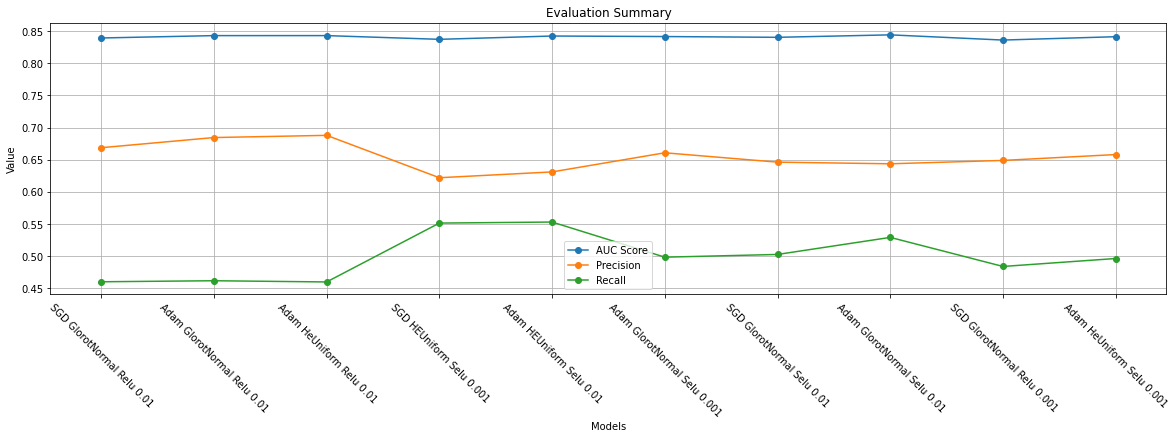

In [102]:
#Evaluation dataframe
model = ["SGD GlorotNormal Relu 0.01",
"Adam GlorotNormal Relu 0.01",
"Adam HeUniform Relu 0.01",
"SGD HEUniform Selu 0.001",
"Adam HEUniform Selu 0.01",
"Adam GlorotNormal Selu 0.001",
"SGD GlorotNormal Selu 0.01",
"Adam GlorotNormal Selu 0.01",
"SGD GlorotNormal Relu 0.001",
"Adam HeUniform Selu 0.001"]

s_eval = pd.concat([pd.Series(model, name ="Model") ,pd.DataFrame(s_grid.cv_results_)],axis=1)

#Graph
plt.figure(figsize=(20,5))
plt.plot(s_eval["Model"].astype(str),s_eval["mean_test_AUC"], marker="o", label="AUC Score")
plt.plot(s_eval["Model"].astype(str),s_eval["mean_test_Precision"], marker="o", label="Precision")
plt.plot(s_eval["Model"].astype(str),s_eval["mean_test_Recall"], marker="o", label="Recall")


plt.xlabel("Models")
plt.ylabel("Value")
plt.legend(loc="best")
plt.title("Evaluation Summary")
plt.xticks(rotation=315)
plt.show()


In [71]:
#Get the best hyperparameter
s_grid.best_params_

{'activation': 'selu',
 'init': keras.initializers.initializers_v2.GlorotNormal,
 'learning_rate': 0.01,
 'optimizer': keras.optimizer_v2.adam.Adam}

In [72]:
#Get the best scores
s_grid.best_score_

0.8443960875612554

From above result, we got best parameter with AUC Score 0,84 as our best model from cross validation cv. The best parameter for sequential model are with hidden activation function selu and weight initializer GlorotNormal. While the otpimization must be used is Adam with learning rate 0,01.

Next, we will define our best model again with those best hyperparameter.

__Wrap best hyperparameter as a final CV model__

In [73]:
#### Final model from crossvalidation ####

#Build model architecture
tun_cv_s_model = keras.models.Sequential()
tun_cv_s_model.add(keras.Input(shape=[8]))
tun_cv_s_model.add(keras.layers.BatchNormalization())
tun_cv_s_model.add(keras.layers.Dropout(rate=0.2))
tun_cv_s_model.add(keras.layers.Dense(128, activation="selu", kernel_initializer=keras.initializers.GlorotNormal(seed=42)))
tun_cv_s_model.add(keras.layers.BatchNormalization())
tun_cv_s_model.add(keras.layers.Dropout(rate=0.2))
tun_cv_s_model.add(keras.layers.Dense(64, activation="selu", kernel_initializer=keras.initializers.GlorotNormal(seed=42)))
tun_cv_s_model.add(keras.layers.BatchNormalization())
tun_cv_s_model.add(keras.layers.Dropout(rate=0.2))
tun_cv_s_model.add(keras.layers.Dense(32, activation="selu", kernel_initializer=keras.initializers.GlorotNormal(seed=42)))
tun_cv_s_model.add(keras.layers.Dense(1, activation="sigmoid"))

#Checkpoint definition
tun_cv_s_model_cp = tf.keras.callbacks.ModelCheckpoint(
    "tun_cv_sequential_ANN.h5",
    monitor = "val_auc",
    save_best_only=True
)

#Compile the model
tun_cv_s_model.compile(loss="binary_crossentropy", 
                          optimizer=keras.optimizers.Adam(learning_rate=0.01), 
                          metrics=["AUC","Precision","Recall","FalseNegatives","FalsePositives","TrueNegatives","TruePositives","accuracy"])

In [74]:
#Train the model
tun_cv_s_history = tun_cv_s_model.fit(X_trains, y_train, epochs=100,
                                   validation_data= (X_valids,y_valid), verbose =2, callbacks=[tun_cv_s_model_cp])

Epoch 1/100
159/159 - 4s - loss: 0.5007 - auc: 0.7766 - precision: 0.5432 - recall: 0.4439 - false_negatives: 748.0000 - false_positives: 502.0000 - true_negatives: 3215.0000 - true_positives: 597.0000 - accuracy: 0.7531 - val_loss: 0.4415 - val_auc: 0.8254 - val_precision: 0.6435 - val_recall: 0.4125 - val_false_negatives: 198.0000 - val_false_positives: 77.0000 - val_true_negatives: 852.0000 - val_true_positives: 139.0000 - val_accuracy: 0.7828
Epoch 2/100
159/159 - 1s - loss: 0.4642 - auc: 0.7981 - precision: 0.5949 - recall: 0.4498 - false_negatives: 740.0000 - false_positives: 412.0000 - true_negatives: 3305.0000 - true_positives: 605.0000 - accuracy: 0.7724 - val_loss: 0.4602 - val_auc: 0.8285 - val_precision: 0.6350 - val_recall: 0.4955 - val_false_negatives: 170.0000 - val_false_positives: 96.0000 - val_true_negatives: 833.0000 - val_true_positives: 167.0000 - val_accuracy: 0.7899
Epoch 3/100
159/159 - 1s - loss: 0.4583 - auc: 0.8044 - precision: 0.6004 - recall: 0.4513 - false

#### Cross Val Functional API ANN


In [75]:
#Set random seed
tf.keras.backend.clear_session
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
#Create function for model
def f_model_cv(optimizer=keras.optimizers.SGD, init=keras.initializers.HeUniform, activation="relu", learning_rate = 0.01):
  #model architecture
  input = keras.layers.Input(shape=[8])

  bn1 = keras.layers.BatchNormalization()(input)
  dp1 = keras.layers.Dropout(rate=0.2)(bn1)
  hid1 = keras.layers.Dense(128, activation=activation, kernel_initializer=init(seed=42))(dp1)

  con = keras.layers.concatenate([input,hid1])

  bn2 = keras.layers.BatchNormalization()(con)
  dp2 = keras.layers.Dropout(rate=0.2)(bn2)
  hid2 = keras.layers.Dense(64, activation=activation, kernel_initializer=init(seed=42))(dp2)

  bn3 = keras.layers.BatchNormalization()(hid2)
  dp3 = keras.layers.Dropout(rate=0.2)(bn3)
  hid3 = keras.layers.Dense(32, activation=activation, kernel_initializer=init(seed=42))(dp3)
  output = keras.layers.Dense(1, activation="sigmoid")(hid3)

  f_model = keras.models.Model(inputs=[input], outputs=[output])

  #compile model
  f_model.compile(loss="binary_crossentropy", 
                optimizer=optimizer(learning_rate=learning_rate), 
                metrics=["AUC","Precision","Recall","FalseNegatives","FalsePositives","TrueNegatives","TruePositives","accuracy"])
  
  return f_model

Same with sequential crossvalidation ANN , for functional ANN we will try model with combination of several hyperparameter including our previous hyperparameter model. The combination will contain :

1. Optimizer : SGD & Adam
2. Weight initializer : GlorotNormal , HeUniform
3. Activation Function of hidden layer : relu and selu
4. Learning Rate : 0.01 and 0.001

In [77]:
#Define hyperparameter 
f_params = {"optimizer":[keras.optimizers.SGD, keras.optimizers.Adam],
          "init": [keras.initializers.GlorotNormal, keras.initializers.HeUniform],
          "activation":["relu","selu"],
          "learning_rate": [0.01, 0.001]}

In [78]:
#Define model wrapper
f_model_wrapper = KerasClassifier(build_fn=f_model_cv, verbose=2, epochs=100, validation_data=(X_valids,y_valid))

#define scoring matrics
scoring = {'F1': "f1", "Precision": "precision", "Recall":"recall", "AUC":"roc_auc_ovr"}

#GridSearchCV
f_grid = RandomizedSearchCV( estimator= f_model_wrapper, param_distributions= f_params, cv=5 , refit="AUC", scoring=scoring, random_state=42 )

In [79]:
#Train the model
f_grid.fit(X_trains,y_train)

Streaming output truncated to the last 5000 lines.
Epoch 1/100
127/127 - 4s - loss: 0.5264 - auc: 0.7646 - precision: 0.5026 - recall: 0.5519 - false_negatives: 475.0000 - false_positives: 579.0000 - true_negatives: 2410.0000 - true_positives: 585.0000 - accuracy: 0.7397 - val_loss: 0.4614 - val_auc: 0.8220 - val_precision: 0.7158 - val_recall: 0.2018 - val_false_negatives: 269.0000 - val_false_positives: 27.0000 - val_true_negatives: 902.0000 - val_true_positives: 68.0000 - val_accuracy: 0.7662
Epoch 2/100
127/127 - 1s - loss: 0.4742 - auc: 0.7872 - precision: 0.5587 - recall: 0.4311 - false_negatives: 603.0000 - false_positives: 361.0000 - true_negatives: 2628.0000 - true_positives: 457.0000 - accuracy: 0.7619 - val_loss: 0.4374 - val_auc: 0.8290 - val_precision: 0.6367 - val_recall: 0.4837 - val_false_negatives: 174.0000 - val_false_positives: 93.0000 - val_true_negatives: 836.0000 - val_true_positives: 163.0000 - val_accuracy: 0.7891
Epoch 3/100
127/127 - 1s - loss: 0.4599 - auc: 0

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fbcd478fcd0>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'activation': ['relu', 'selu'],
                                        'init': [<class 'keras.initializers.initializers_v2.GlorotNormal'>,
                                                 <class 'keras.initializers.initializers_v2.HeUniform'>],
                                        'learning_rate': [0.01, 0.001],
                                        'optimizer': [<class 'keras.optimizer_v2.gradient_descent.SGD'>,
                                                      <class 'keras.optimizer_v2.adam.Adam'>]},
                   pre_dispatch='2*n_jobs', random_state=42, refit='AUC',
                   return_train_score=False,
                   scoring={'AUC': 'roc_auc_ovr', 'F1': 'f1',
                            'Precision': 'precision', 'R

__Get the best hyperparameters with its score__

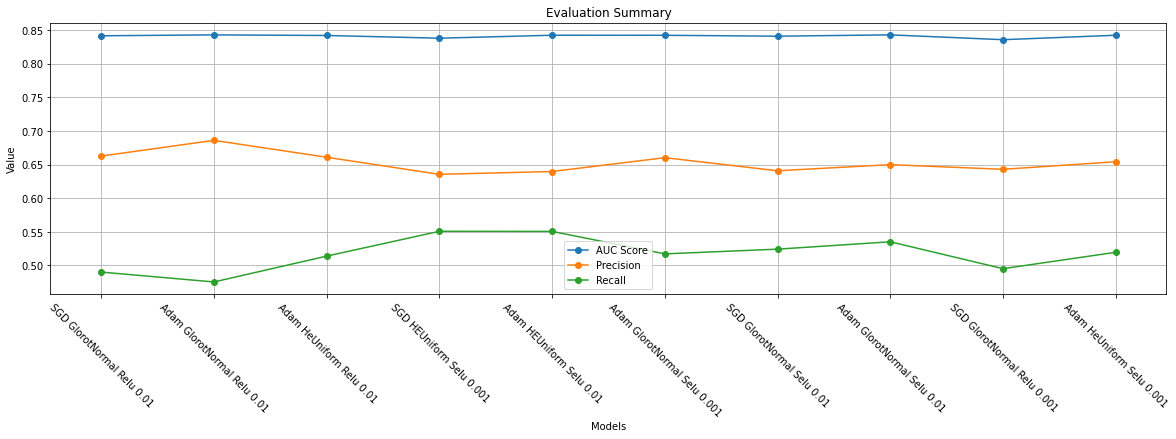

In [107]:
#Evaluation dataframe
model = ["SGD GlorotNormal Relu 0.01",
"Adam GlorotNormal Relu 0.01",
"Adam HeUniform Relu 0.01",
"SGD HEUniform Selu 0.001",
"Adam HEUniform Selu 0.01",
"Adam GlorotNormal Selu 0.001",
"SGD GlorotNormal Selu 0.01",
"Adam GlorotNormal Selu 0.01",
"SGD GlorotNormal Relu 0.001",
"Adam HeUniform Selu 0.001"]

f_eval = pd.concat([pd.Series(model, name ="Model") ,pd.DataFrame(f_grid.cv_results_)],axis=1)


#Graph
plt.figure(figsize=(20,5))
plt.plot(f_eval["Model"].astype(str),f_eval["mean_test_AUC"], marker="o", label="AUC Score")
plt.plot(f_eval["Model"].astype(str),f_eval["mean_test_Precision"], marker="o", label="Precision")
plt.plot(f_eval["Model"].astype(str),f_eval["mean_test_Recall"], marker="o", label="Recall")


plt.xlabel("Models")
plt.ylabel("Value")
plt.legend(loc="best")
plt.title("Evaluation Summary")
plt.xticks(rotation=315)
plt.show()


In [81]:
#Get the best hyperparameter
f_grid.best_params_

{'activation': 'selu',
 'init': keras.initializers.initializers_v2.GlorotNormal,
 'learning_rate': 0.01,
 'optimizer': keras.optimizer_v2.adam.Adam}

In [82]:
#Get the best scores
f_grid.best_score_

0.8427061967487537

From above result, we got best parameter with AUC Score 0,842 as our best model from cross validation cv. The best parameter for functional model are with hidden activation function selu and weight initializer GlorotNormal. While the otpimization must be used is Adam with learning rate 0,01. Same with best parameter of sequential cross validation.

Next, we will define our best model again with those best hyperparameter.

__Wrap best hyperparameter as a final CV model__

In [83]:
#### Final model from crossvalidation ####

#Build the architecture
t_cv_input = keras.layers.Input(shape=[8])

t_cv_bn1 = keras.layers.BatchNormalization()(t_cv_input)
t_cv_dp1 = keras.layers.Dropout(rate=0.2)(t_cv_bn1)
t_cv_hid1 = keras.layers.Dense(128, activation="selu", kernel_initializer=keras.initializers.GlorotNormal(seed=42))(t_cv_dp1)
t_cv_con = keras.layers.concatenate([t_cv_input,t_cv_hid1])

t_cv_bn2 = keras.layers.BatchNormalization()(t_cv_con)
t_cv_dp2 = keras.layers.Dropout(rate=0.2)(t_cv_bn2)
t_cv_hid2 = keras.layers.Dense(64, activation="selu", kernel_initializer=keras.initializers.GlorotNormal(seed=42))(t_cv_dp2)

t_cv_bn3 = keras.layers.BatchNormalization()(t_cv_hid2)
t_cv_dp3 = keras.layers.Dropout(rate=0.2)(t_cv_bn3)
t_cv_hid3 = keras.layers.Dense(32, activation="selu", kernel_initializer=keras.initializers.GlorotNormal(seed=42))(t_cv_dp3)
t_cv_output = keras.layers.Dense(1, activation="sigmoid")(t_cv_hid3)

tun_cv_f_model = keras.models.Model(inputs=[t_cv_input], outputs=[t_cv_output])

#Checkpoint definition
tun_cv_f_model_cp = tf.keras.callbacks.ModelCheckpoint(
    "tun_cv_functional_ANN.h5",
    monitor = "val_auc",
    save_best_only=True
)

#Compile the model
tun_cv_f_model.compile(loss="binary_crossentropy", 
                          optimizer=keras.optimizers.Adam(learning_rate=0.01), 
                          metrics=["AUC","Precision","Recall","FalseNegatives","FalsePositives","TrueNegatives","TruePositives","accuracy"])

In [84]:
#Train the model
tun_cv_f_history = tun_cv_f_model.fit(X_trains, y_train, epochs=100,
                                   validation_data= (X_valids,y_valid), verbose =2, callbacks=[tun_cv_f_model_cp])

Epoch 1/100
159/159 - 3s - loss: 0.4987 - auc: 0.7805 - precision: 0.5495 - recall: 0.4543 - false_negatives: 734.0000 - false_positives: 501.0000 - true_negatives: 3216.0000 - true_positives: 611.0000 - accuracy: 0.7560 - val_loss: 0.4445 - val_auc: 0.8281 - val_precision: 0.6842 - val_recall: 0.3086 - val_false_negatives: 233.0000 - val_false_positives: 48.0000 - val_true_negatives: 881.0000 - val_true_positives: 104.0000 - val_accuracy: 0.7780
Epoch 2/100
159/159 - 0s - loss: 0.4611 - auc: 0.8027 - precision: 0.5967 - recall: 0.4610 - false_negatives: 725.0000 - false_positives: 419.0000 - true_negatives: 3298.0000 - true_positives: 620.0000 - accuracy: 0.7740 - val_loss: 0.4562 - val_auc: 0.8294 - val_precision: 0.6650 - val_recall: 0.4065 - val_false_negatives: 200.0000 - val_false_positives: 69.0000 - val_true_negatives: 860.0000 - val_true_positives: 137.0000 - val_accuracy: 0.7875
Epoch 3/100
159/159 - 0s - loss: 0.4558 - auc: 0.8077 - precision: 0.5994 - recall: 0.4506 - false

#### Best Param Cross Validation Model Evaluation

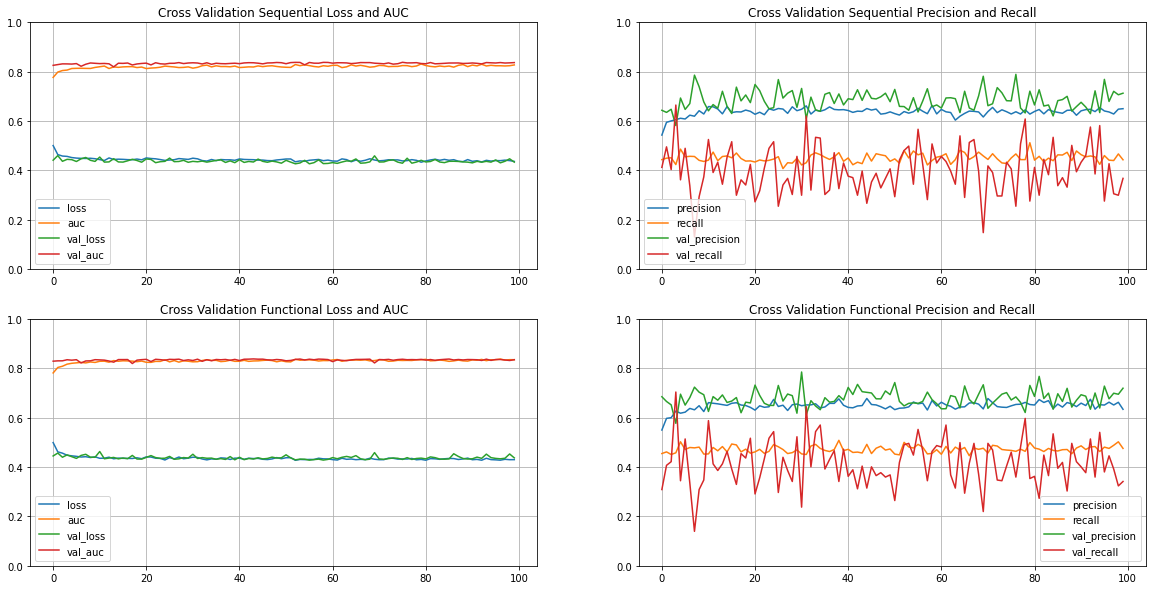

In [85]:
#Evaluation Tunned Sequential API
tun_cv_s_loss_auc = {k: tun_cv_s_history.history[k] for k in ["loss","auc","val_loss","val_auc"]}
tun_cv_s_prec_rec = {k: tun_cv_s_history.history[k] for k in ["precision","recall","val_precision","val_recall"]}

#Evaluation Tunned  Functional API
tun_cv_f_loss_auc = {k: tun_cv_f_history.history[k] for k in ["loss","auc","val_loss","val_auc"]}
tun_cv_f_prec_rec = {k: tun_cv_f_history.history[k] for k in ["precision","recall","val_precision","val_recall"]}

fig, ax = plt.subplots(2,2,figsize=(20, 10))

plt.rcParams['axes.grid'] = True
plt.setp(ax, ylim=(0,1))
pd.DataFrame(tun_cv_s_loss_auc).plot(ax=ax[0,0])
ax[0,0].set_title("Cross Validation Sequential Loss and AUC")
pd.DataFrame(tun_cv_s_prec_rec).plot(ax=ax[0,1])
ax[0,1].set_title("Cross Validation Sequential Precision and Recall")

pd.DataFrame(tun_cv_f_loss_auc).plot(ax=ax[1,0])
ax[1,0].set_title("Cross Validation Functional Loss and AUC")
pd.DataFrame(tun_cv_f_prec_rec).plot(ax=ax[1,1])
ax[1,1].set_title("Cross Validation Functional Precision and Recall")

#plt.savefig("Adam_BNorm_Drop.png")
plt.show()

From above result, we could see the result of our best CV model almost same with tunned basic model before. Even from precision and recall perspective, it's worse than our tunned basic model before. Our best CV model has fluctuative precision and recall while our previous tunned basic model are more constant.

## Model Evaluation

At previous session, we have tried create basic model ANN with sequential and functional API. After that we've tunned those model using BatchNormalization and Dropout. The results, seems not satisfied us, then we've tried to tunned it again using crossvalidation concept to get the best hyperparameter of every combination models.

We've also already saved each of model before and now in this section we will load each model to test it with our validation dataset. After that we will compare each valuation of each model to decide which model will be used in inference.

In [110]:
### Load each of previous model ###

#Basic sequential ANN model
best_s_basic = keras.models.load_model("model/basic_sequential_ANN.h5")

#Basic functional API ANN model
best_f_basic = keras.models.load_model("model/basic_functional_ANN.h5") 

#Tunned sequential ANN model
best_tun_s_basic = keras.models.load_model("model/tun_basic_sequential_ANN.h5")

#Tunned functional API ANN model
best_tun_f_basic = keras.models.load_model("model/tun_basic_functional_ANN.h5")

#CV Tunned sequential ANN model
best_tun_s_cv = keras.models.load_model("model/tun_cv_sequential_ANN.h5")

#CV Tunned functional ANN model
best_tun_f_cv = keras.models.load_model("model/tun_cv_functional_ANN.h5")


In [111]:
### Evaluate every model ###

result =[]

for model in [best_s_basic,best_f_basic,best_tun_s_basic,best_tun_f_basic, best_tun_s_cv, best_tun_f_cv]:
  res = model.evaluate(X_valids,y_valid)
  result.append(res)


40/40 [==============================] - 1s 2ms/step - loss: 0.4467 - auc: 0.8186 - precision: 0.6194 - recall: 0.4540 - false_negatives: 184.0000 - false_positives: 94.0000 - true_negatives: 835.0000 - true_positives: 153.0000 - accuracy: 0.7804


Below result are the evaluation of each model agains valid dataset. For Recall and Precision are focusing to positive label which is label 1 (customer churn).

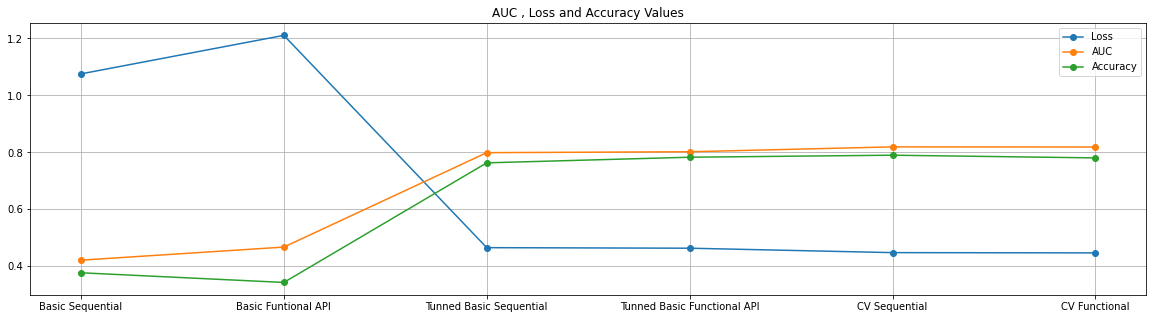

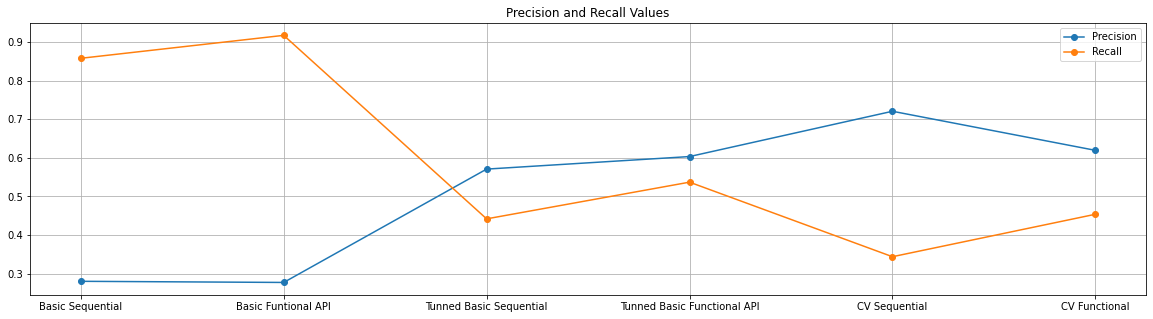

Model      Loss  ...  True Positives  Accuracy
0             Basic Sequential  1.075585  ...           289.0  0.376777
1          Basic Funtional API  1.210960  ...           309.0  0.342812
2      Tunned Basic Sequential  0.465052  ...           149.0  0.763033
3  Tunned Basic Functional API  0.463107  ...           181.0  0.782780
4                CV Sequential  0.447580  ...           116.0  0.789889
5                CV Functional  0.446705  ...           153.0  0.780411

[6 rows x 10 columns]

In [112]:
#Summary of evaluation
eval = pd.DataFrame([x for x in result], columns=["Loss","AUC","Precision","Recall","False Negatives","False Positives","True Negatives","True Positives","Accuracy"])
eval = pd.concat([pd.Series(["Basic Sequential","Basic Funtional API","Tunned Basic Sequential","Tunned Basic Functional API","CV Sequential","CV Functional"], name = "Model"),eval], axis=1)

#Graph
plt.figure(figsize=(20,5))
plt.grid(True)
plt.plot(eval['Model'],eval["Loss"], label="Loss", marker ="o")
plt.plot(eval['Model'],eval["AUC"], label="AUC", marker ="o")
plt.plot(eval['Model'],eval["Accuracy"], label="Accuracy", marker ="o")
plt.title("AUC , Loss and Accuracy Values")
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.grid(True)
plt.plot(eval['Model'],eval["Precision"], label="Precision", marker ="o")
plt.plot(eval['Model'],eval["Recall"], label="Recall", marker ="o")
plt.title("Precision and Recall Values")
plt.legend()
plt.show()

eval


In churn context, we prefer to choose model with high AUC, low loss and balanced Precision and Recall. 

From first graph above, we could see Tunned Basic Sequential until CV Functional model might be our candidates for best model related its AUC, Accuracy and loss because these 4 models has high AUC , accuracy and loss. But Basic Sequential and Basic Functional has high loss and low AUC.

At the other hand, when we look at second graph, Basic Sequential and Basic Functional has highest precision value than others but these recall are very low. Because of it and its low AUC we will ignore this 2 models. Now , let's take a look 4 last models. These have vary precision and recall.  CV Sequential has highest precision but lowest recall. Since we prefer the balanced value of model, we will choose Tunned Basic Functional API as our best model.

Tunned Basic Functional has pretty high AUC and low loss, and also it has balanced precision and recall evanthough there is model with better precision or better recall. This model has precision score 0.60 and recall score 0.53 means this model has 60% ability to predict right churn and 53% ability to not predict customer who is churn as not churn.

Not only that, recalling Tunned Basic Functional graph at modeling section, this graph is representing the most fit model than others. Others model tend to overfit/underfit while this model looks constant.

The conclusion, Tunned Basic Functional is best classification model because it's the most fit model eventhough it's precision and recall is not that high, atleast they're balanced.



## Model Inference

In this section, we will inference our test dataset with best model we've chosen in model evaluation chapter before.

We've preprocess our test data before, so in here we're only use it.

In [113]:
#Predict test dataset using bestmodel
y_pred = (best_tun_f_basic.predict(X_tests) > 0.5).astype("int32")

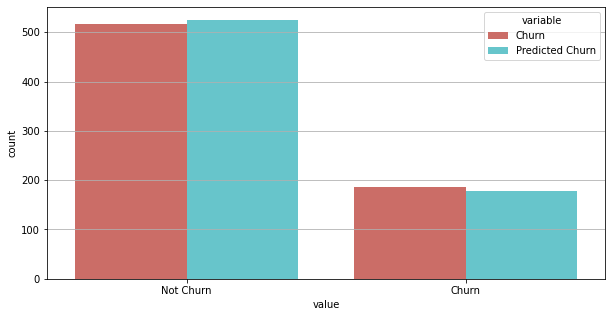

In [114]:
#Compare y prediction against y result

gr = pd.melt(pd.DataFrame({"Churn": y_test, "Predicted Churn": np.ravel(y_pred)}))
plt.figure(figsize=(10,5));
g1 =sns.countplot(data=gr, x="value",  palette="hls", hue="variable")
g1.set_xticklabels(['Not Churn', 'Churn'])
plt.show()


From above result, we could see the prediction vs actual churn customer for test dataset almost same with our best model.

## Conclusion


1. There is 27% of customer churn in latest month.
2. Mostly churn is happening against customer with 1 month tenure. We might guess it's happening because there are so many customer who subscribe the service because some beneficial promotion at first tenure but for the next tenure they decided to leave because there is not promotion anymore.
3. Gender is not affecting total customer of churn while age , marital and child might affecting. Senior citizen tend to churn , it might due to their low knowledge of telco services than the young citizen. While customer who already married or having children tend to churn because they might have another bills to pay for their family than only use for their handphone/telephone services.
4. From all customer data, we could see the most popular service subscribed by customer are Phone Services and Internet Services. 
5. From all dataset , 37% of customer are subcribed full services (phone, multiplelines and internet) while the rest they subscribe 1 or 2 of those 3 general services provided. From those portion, the trend of churn customer :
  - 32% from customer who subscribed fully service are churn
  - 23% from customer who subscribed 1/2 services are churn
6. If we spesificially looking at customer who subscribe internet services, we could see customer who has subscribed internet service has low churn. We might guess customer are satisfied with the internet services provided.
7.From contract and payment perspective, customer who has contract month to month and using payment/billing electronic tend to churn because it's more easy to churn with no effort.
8. Customer churn are customer who has high monthly charge while loyal customer is not customer who pay high for their service but customer who has high bills are the churn customer.
9. Tunned Basic Functional has pretty high AUC and low loss, and also it has balanced precision and recall evanthough there is model with better precision or better recall. This model has precision score 0.60 and recall score 0.53 means this model has 60% ability to predict right churn and 53% ability to not predict customer who is churn as not churn.The conclusion, Tunned Basic Functional is best classification model because it's the most fit model eventhough it's precision and recall is not that high, atleast they're balanced.